In [3]:
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
import random
import noise

In [2]:
!pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56275 sha256=8bac7ca76362d83110d0b10165eaeba6683922b465b1bdb798bcca6f0f8b0df9
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


# Requirement 1: Pricing and Advertising in a Stochastic Environment


## Parameters

In [ ]:
class ParametersReq1:
    ''' The class just implements the parameters of the algorithms '''
    def __init__(self):
        # pricing
        self.conversion_probability = lambda p : 1-p # It will corresponds to the price curve
        self.days = 90 #Number of days for our simulation of the pricing's campaign
        self.discretization_price = 1000 # number of sample in price grid
        self.learning_rate_pricing = 1/np.sqrt(self.days)
        self.cost = 0.5
        self.scale = 2

        # bidding
        self.users=5000
        self.ctrs = np.array([1, 1, 1, 1])# Click-To-Rates Ratio for every advs
        self.my_valuation = 0.6 # It correponds to the true valuation of the item by the company,
        self.discretization_bid = 6
        self.budget = 500 #Budget of the advertiser
        self.learning_rate_bidding = 1/np.sqrt(self.users) # Learning rate for bidding's alg.
        self.n_advertisers = 4 #Number of advertisers
        self.range_f = 0.1 #Coefficient for the exploration term (ucbs) utility
        self.range_c = 0.1 #Coefficient for the exploration term (ucbs) cost



## Pricing with Gaussian Process

In [ ]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in np.arange(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

## Environment: pricing

In [ ]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

## Agent pricing (GP-UCB)

In [ ]:
class GPUCBAgent:
    def __init__(self, days, discretization_price):
        self.days = days
        self.available_price = np.linspace(0, 1, discretization_price) # discretize the prices
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.price_ind = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization_price)
        self.sigma_t = np.zeros(discretization_price)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(days)))

        self.N_pulls = np.zeros(discretization_price)
        self.day = 0

    def set_price(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.available_price)
        ucbs = self.mu_t + self.beta(self.day) * self.sigma_t
        self.price_ind = np.argmax(ucbs)
        return self.available_price[self.price_ind]

    def update(self, r_t):
        self.N_pulls[self.price_ind] += 1
        self.action_hist = np.append(self.action_hist, self.available_price[self.price_ind])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.available_price[self.price_ind], r_t)
        self.day += 1

In [ ]:
params = ParametersReq1()
conversion_probability = lambda p: 1-p
available_prices = np.linspace(0, 1, params.discretization_price)
reward_function = lambda price, n_sales: (price-params.cost)*n_sales
maximum_profit = reward_function(1, params.users)

agent = GPUCBAgent(days= params.days, discretization_price=params.discretization_price)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=params.cost)

profit_curve = reward_function(available_prices, params.users*conversion_probability(available_prices))
best_price_index = np.argmax(profit_curve)
best_price = available_prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], params.days)
agent_rewards = np.array([])

for t in range(params.days):
    p_t = agent.set_price()
    d_t, r_t = env.round(p_t, n_t=params.users)
    agent.update(r_t/params.users)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

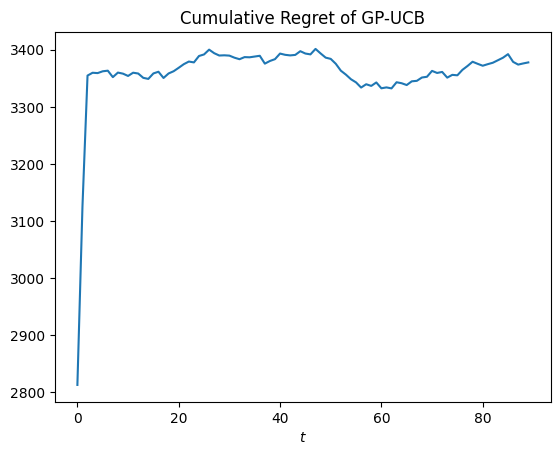

In [ ]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

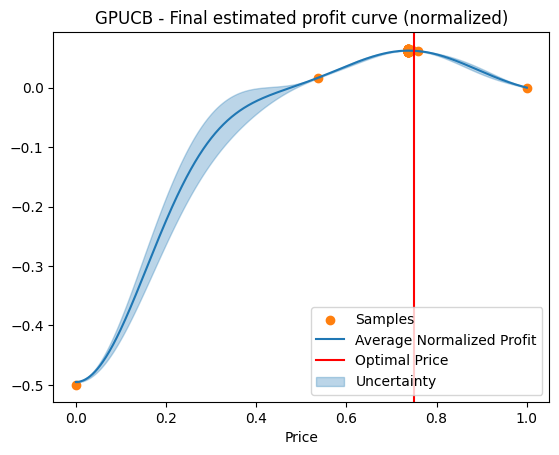

In [ ]:
profits = agent.reward_hist
prices = agent.action_hist
gp = RBFGaussianProcess(scale=20)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(0,1,params.discretization_price))
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(0,1,params.discretization_price), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,params.discretization_price), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

## Environment: second price auction (truthful)



In [ ]:
class SecondPriceAuction():
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self,bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values

    def get_payments_per_click(self, winners, values):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

    def auction(self, bids):
        winners, values = self.get_winners(bids)
        payments_per_click = self.get_payments_per_click(winners, values)
        return winners, payments_per_click

---
## Agent (only bidding): UCB-like

In [ ]:
class UCB_Bidding_Agent:
    def __init__(self, budget, users, range_f, range_c, discretization_bid):
        self.discretization_bid = discretization_bid
        self.available_bids = np.linspace(0,1,discretization_bid)
        self.N_bid_pulls = np.zeros(discretization_bid)
        self.budget = budget
        self.users = users
        self.rho = self.budget/self.users
        self.auction = 0
        self.range_f = range_f
        self.range_c = range_c
        self.bid_ind = None

        self.average_utilities = np.zeros(discretization_bid)
        self.average_costs = np.zeros(discretization_bid)
        self.Gamma = np.zeros(discretization_bid)

    def bid(self):
        if self.budget < 1:
          self.bid_ind = 0
          return self.bid_ind
        else:
            if self.auction < self.discretization_bid:
                self.bid_ind = self.auction
            else:
                self.bid_ind = np.random.choice(a = range(self.discretization_bid), p=self.Gamma.x)
            return self.available_bids[int(self.bid_ind)]

    def update_bidding(self, f_t, c_t):
        self.N_bid_pulls[self.bid_ind] += 1
        self.average_utilities[self.bid_ind] += (f_t - self.average_utilities[self.bid_ind])/self.N_bid_pulls[self.bid_ind]
        self.average_costs[self.bid_ind] += (c_t - self.average_costs[self.bid_ind])/self.N_bid_pulls[self.bid_ind]

        f_ucb = np.zeros(self.discretization_bid)
        c_lcb = np.zeros(self.discretization_bid)

        for u in range(self.discretization_bid):
            f_ucb[u] = self.average_utilities[u]
            c_lcb[u] = self.average_costs[u]

        for u in range(self.discretization_bid):
            if self.N_bid_pulls[u] > 0:
                f_ucb[u] += self.range_f*np.sqrt(2*np.log(self.users)/(self.N_bid_pulls[u]))
                c_lcb[u] -= self.range_c*np.sqrt(2*np.log(self.users)/(self.N_bid_pulls[u]))

        c = -f_ucb
        A_ub = [c_lcb]
        b_ub = [self.rho]
        A_eq = [np.ones(self.discretization_bid)]
        b_eq = [1]
        self.Gamma = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        self.auction += 1
        self.budget -= c_t


In [ ]:
params = ParametersReq1()

other_bids = np.random.uniform(0, 1, size = (params.n_advertisers-1, params.users))
m_t = other_bids.max(axis=0)

agent = UCB_Bidding_Agent(
    budget=params.budget,
    users=params.users,
    range_f=params.range_f,
    range_c=params.range_c,
    discretization_bid=params.discretization_bid
)

auction = SecondPriceAuction(params.ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(42)
for u in range(params.users):
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.auction(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (params.my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update_bidding(f_t, c_t)
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 890


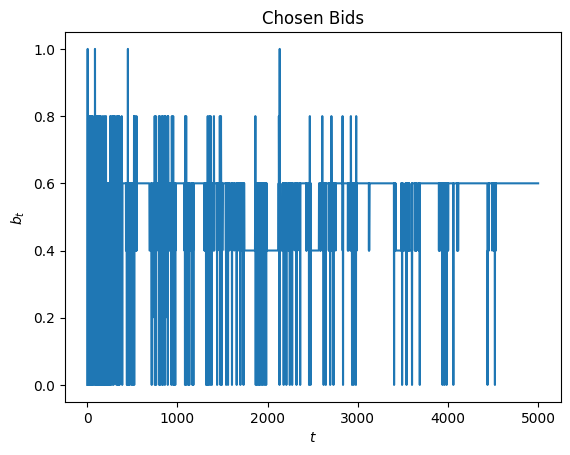

In [ ]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


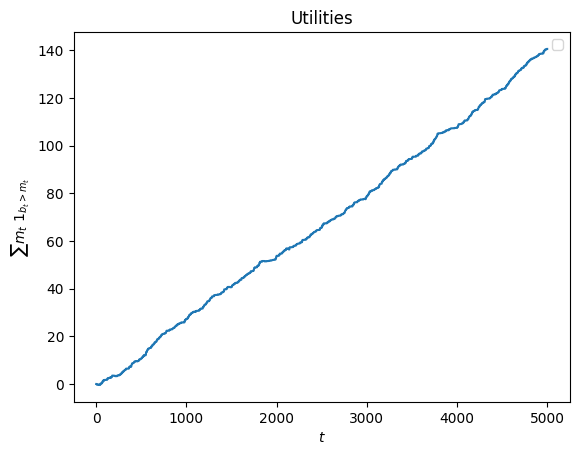

In [ ]:
plt.title('Utilities')
plt.plot(np.cumsum(utilities))
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

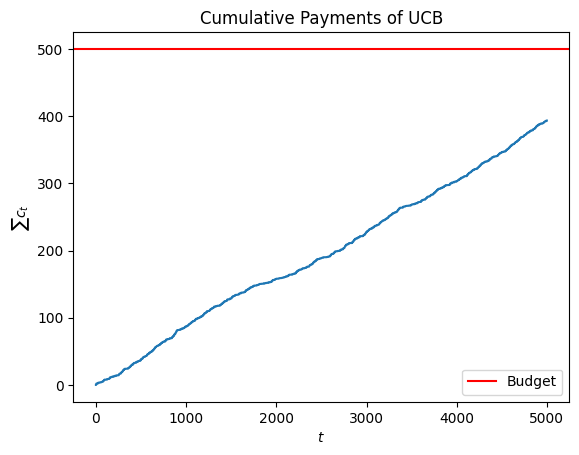

In [ ]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(params.budget, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB')
plt.show()

In [ ]:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    sorted_round_utility = np.flip(np.argsort(utility))
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [ ]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(params.budget, params.my_valuation, m_t, params.users)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


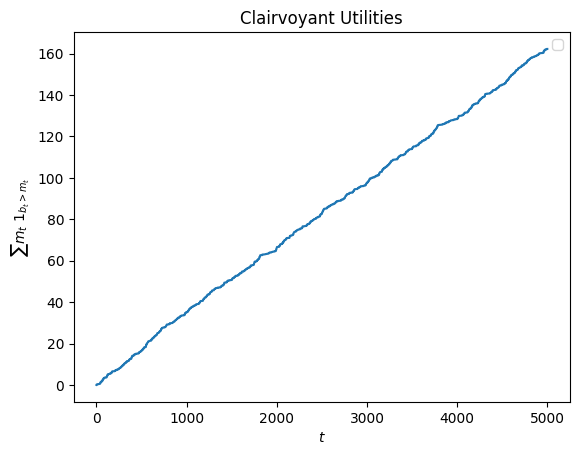

In [ ]:
plt.title('Clairvoyant Utilities')
plt.plot(np.cumsum(clairvoyant_utilities))
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

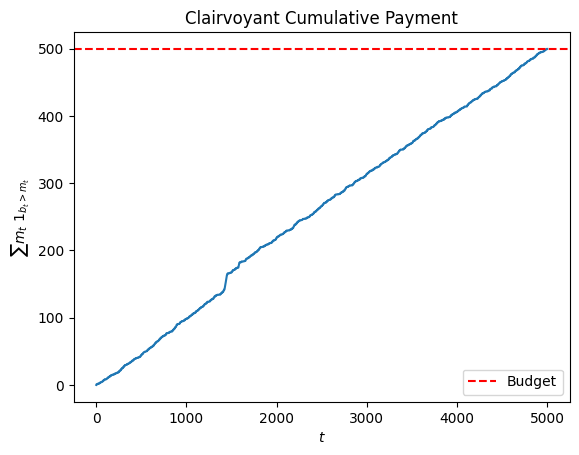

In [ ]:
plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(params.budget, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

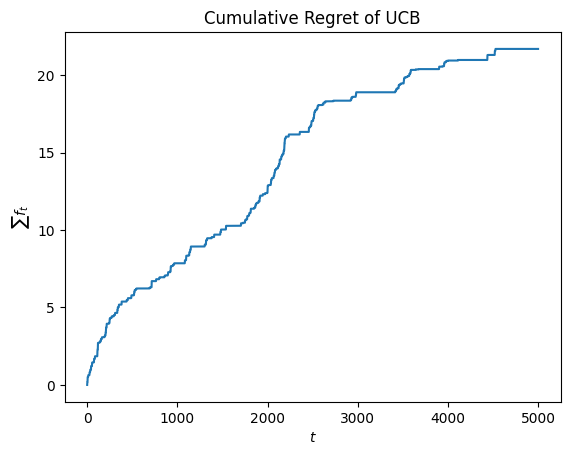

In [ ]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of UCB')
plt.show()

---

##  Environment: Pricing and Advertising

In [ ]:
class EnvironmentFull:
    def __init__(self, users ,ctrs, conversion_probability, cost, prominence, budget):
        # pricing
        self.conversion_probability = conversion_probability
        self.reward = 0
        self.cost = cost
        self.d_t=0

        # bidding
        self.users = users
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs) -1
        self.prominence = prominence
        self.budget = budget
        self.t = 0

    def day(self, price):
        self.reward = 0
        self.price = price
        self.other_bids = np.random.uniform(0, 1, size = (self.n_adv, self.users))
        self.m_t = np.max(self.other_bids, axis = 0)

    def get_winners(self):
        adv_values = self.ctrs*self.bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values

    def get_payments_per_click(self, winners, values):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

    def auction(self, my_bid, t):
        self.bids = np.append(my_bid, self.other_bids[:, t].ravel())
        winners, values = self.get_winners()
        payments_per_click = self.get_payments_per_click(winners, values)
        return winners, payments_per_click

    def request(self):
        x = np.random.binomial(1, self.prominence)
        if x != 0:
            self.d_t = np.random.binomial(1, self.conversion_probability(self.price))
        r_t = (self.price - self.cost) * self.d_t
        return r_t



## Agent: Pricing and Advertising (GP-UCB)

In [ ]:
class GPUCBAgent_Pricing_and_Bidding:
    def __init__(self, days, budget, users, range_f, range_c, discretization_price, discretization_bid, scale):

        self.available_price = np.linspace(0, 1, discretization_price)
        self.gp = RBFGaussianProcess(scale=scale).fit()
        self.price_ind = None
        self.price_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization_price)
        self.sigma_t = np.zeros(discretization_price)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(days)))
        self.N_price_pulls = np.zeros(discretization_price)
        self.day = 0
        self.days = days

        self.discretization_bid = discretization_bid
        self.available_bid = np.linspace(0,1,discretization_bid)
        self.N_bid_pulls = np.zeros(discretization_bid)
        self.budget = budget
        self.users= users
        self.rho = self.budget/self.users
        self.auction = 0

        self.range_f = range_f
        self.range_c = range_c
        self.bid_ind = None

        self.average_utilities = np.zeros(self.discretization_bid)
        self.average_costs = np.zeros(self.discretization_bid)
        self.Gamma = np.zeros(self.discretization_bid)

    def bid(self):
        if self.budget < 1:
          self.bid_ind=0
          return self.bid_ind
        else:
            if self.auction < self.discretization_bid:
                self.bid_ind = self.auction
            else:
                self.bid_ind = np.random.choice(a = range(self.discretization_bid), p=self.Gamma.x)
            return self.available_bid[int(self.bid_ind)]

    def update_bidding(self, f_t, c_t):
        self.N_bid_pulls[self.bid_ind] += 1
        self.average_utilities[self.bid_ind] += (f_t - self.average_utilities[self.bid_ind])/self.N_bid_pulls[self.bid_ind]
        self.average_costs[self.bid_ind] += (c_t - self.average_costs[self.bid_ind])/self.N_bid_pulls[self.bid_ind]

        f_ucb = np.zeros(self.discretization_bid)
        c_lcb = np.zeros(self.discretization_bid)

        for u in range(self.discretization_bid):
            f_ucb[u] = self.average_utilities[u]
            c_lcb[u] = self.average_costs[u]

        for u in range(self.discretization_bid):
            if self.N_bid_pulls[u] > 0:
                f_ucb[u] += self.range_f*np.sqrt(2*np.log(self.users)/(self.N_bid_pulls[u]))
                c_lcb[u] -= self.range_c*np.sqrt(2*np.log(self.users)/(self.N_bid_pulls[u]))

        c = -f_ucb
        A_ub = [c_lcb]
        b_ub = [self.rho]
        A_eq = [np.ones(self.discretization_bid)]
        b_eq = [1]
        self.Gamma = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        self.auction += 1
        self.budget -= c_t

    def set_price(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.available_price)
        ucbs = self.mu_t + self.beta(self.day) * self.sigma_t
        self.price_ind = np.argmax(ucbs)
        return self.available_price[self.price_ind]

    def update_pricing(self, r_t):
        self.N_price_pulls[self.price_ind] += 1
        self.price_hist = np.append(self.price_hist, self.available_price[self.price_ind])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.available_price[self.price_ind], r_t)
        self.day += 1


In [ ]:
params = ParametersReq1()
env = EnvironmentFull(users=params.users, ctrs= params.ctrs, conversion_probability=params.conversion_probability, cost = params.cost, prominence=1, budget = params.budget)
agent = GPUCBAgent_Pricing_and_Bidding(days= params.days, budget= params.budget, users= params.users, range_f= params.range_f, range_c= params.range_c, discretization_price= params.discretization_price, discretization_bid= params.discretization_bid, scale= params.scale)

reward_per_day = []
regret_bidding_per_day = []
users_per_day = []

for day in range(params.days):
    print('day',day)
    agent.N_bid_pulls = np.zeros(params.discretization_bid)
    agent.budget = params.budget
    agent.auction = 0
    agent.bid_ind = None
    agent.average_utilities = np.zeros(params.discretization_bid)
    agent.average_costs = np.zeros(params.discretization_bid)
    agent.Gamma = np.zeros(params.discretization_bid)

    price = agent.set_price()
    env.day(price)
    clairvoyant_bids_per_day, clairvoyant_utilities_per_day, clairvoyant_payments_per_day = get_clairvoyant_truthful(params.budget, params.my_valuation, env.m_t, params.users)

    reward_per_auction = []
    utilities_per_auction = []
    users_per_auction =0
    reward = 0

    for user in np.arange(env.users):
        my_bid = agent.bid()
        winners, payments = env.auction(my_bid, user)
        my_win = int(winners==0)
        f_t, c_t = (params.my_valuation - env.m_t[user])*my_win, env.m_t[user]*my_win
        agent.update_bidding(f_t, c_t)
        r_t = 0
        if my_win:
            r_t = env.request()
            users_per_auction+=env.d_t
        reward += r_t
        utilities_per_auction.append(f_t)

    regret_bidding_per_day.append(np.cumsum(clairvoyant_utilities_per_day-np.array(utilities_per_auction)))
    users_per_day.append(users_per_auction)
    reward_per_day.append(reward)
    agent.update_pricing(reward/params.users)


day 0
day 1
day 2
day 3
day 4
day 5
day 6
day 7
day 8
day 9
day 10
day 11
day 12
day 13
day 14
day 15
day 16
day 17
day 18
day 19
day 20
day 21
day 22
day 23
day 24
day 25
day 26
day 27
day 28
day 29
day 30
day 31
day 32
day 33
day 34
day 35
day 36
day 37
day 38
day 39
day 40
day 41
day 42
day 43
day 44
day 45
day 46
day 47
day 48
day 49
day 50
day 51
day 52
day 53
day 54
day 55
day 56
day 57
day 58
day 59
day 60
day 61
day 62
day 63
day 64
day 65
day 66
day 67
day 68
day 69
day 70
day 71
day 72
day 73
day 74
day 75
day 76
day 77
day 78
day 79
day 80
day 81
day 82
day 83
day 84
day 85
day 86
day 87
day 88
day 89


In [ ]:
avg_regret = np.array(regret_bidding_per_day).mean(axis=0)
std_regret = np.array(regret_bidding_per_day).std(axis=0)

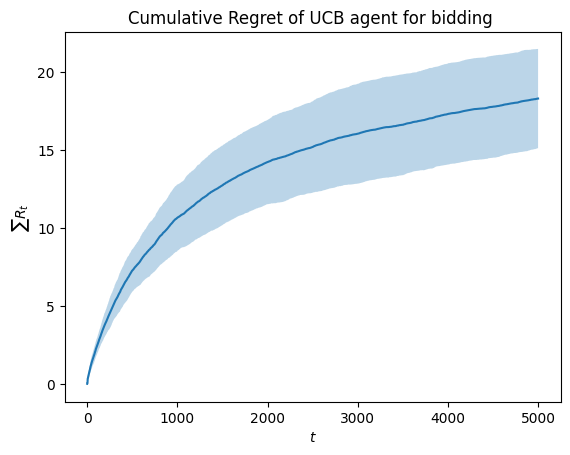

In [ ]:
plt.plot(np.arange(params.users), avg_regret)
plt.fill_between(np.arange(params.users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB agent for bidding ')
plt.show()

---

In [ ]:
reward_function = lambda price, n_sales: (price-params.cost)*n_sales
prices = np.linspace(0, 1, params.discretization_price)
profit_curve = reward_function(prices, params.users*params.conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = []
for u in users_per_day:
  expected_clairvoyant_rewards.append(reward_function(best_price,u))

In [ ]:
print(np.array(agent.price_hist))

[0.         1.         0.50750751 0.76176176 0.74974975 1.
 0.38038038 0.71171171 0.70970971 0.70870871 0.70770771 0.70670671
 0.70670671 1.         0.70770771 0.70670671 0.70670671 0.70570571
 0.71771772 0.64564565 0.76476476 0.66566567 0.76176176 0.73373373
 0.65565566 0.76176176 0.75075075 0.67767768 0.74974975 0.74274274
 0.68868869 0.75175175 0.67667668 0.75475475 0.67967968 0.75375375
 0.74274274 0.6976977  0.75075075 0.74674675 0.67267267 0.75075075
 0.68968969 0.74774775 0.73173173 1.         0.7027027  0.72572573
 0.72372372 0.69369369 0.74174174 0.73673674 0.68368368 0.74174174
 0.73473473 0.73373373 0.67267267 0.74974975 0.74374374 0.73873874
 0.73073073 0.72572573 0.68168168 0.73373373 0.72072072 0.68468468
 0.74374374 0.69069069 0.73173173 0.68768769 0.73973974 0.73973974
 0.73073073 0.67967968 0.73473473 0.72772773 0.68568569 0.74374374
 0.74074074 0.72872873 0.68568569 0.73473473 0.72372372 0.69369369
 0.73973974 0.73373373 0.69069069 0.72472472 0.68868869 0.72572573]


In [ ]:
print(best_price)

0.7497497497497497


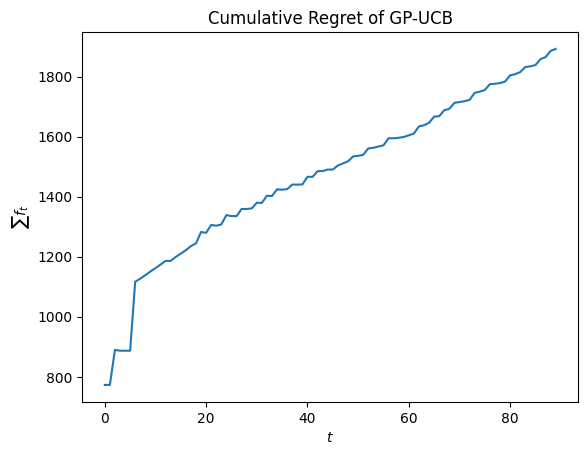

In [ ]:
cumulative_regret = np.cumsum(np.array(expected_clairvoyant_rewards)-np.array(reward_per_day))
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of GP-UCB')
plt.show()

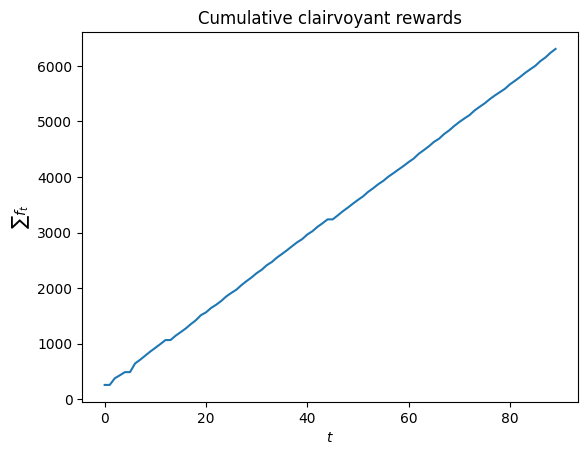

In [ ]:
cumulative_regret = np.cumsum(np.array(expected_clairvoyant_rewards))
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative clairvoyant rewards')
plt.show()

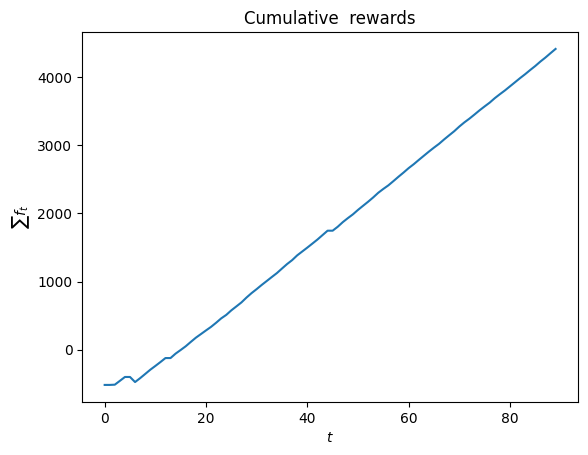

In [ ]:
cumulative_regret = np.cumsum(np.array(reward_per_day))
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative  rewards')
plt.show()

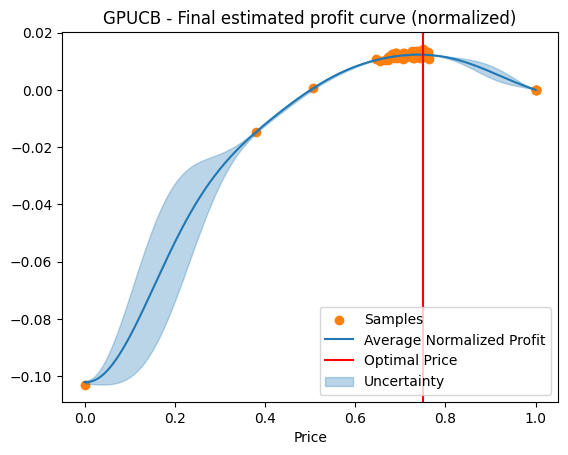

In [ ]:
profits = agent.reward_hist
prices = agent.price_hist
gp = RBFGaussianProcess(scale=20)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(0,1,params.discretization_price))
sigma /= 20
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(0,1,params.discretization_price), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,params.discretization_price), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

---
## Agent (only bidding): Primal Dual

In [ ]:
''' Pacing Strategy '''
class PrimalDualAgent_NoPricing:
    def __init__(self, valuation, budget, learning_rate_bidding, users):
        self.valuation = valuation
        self.budget = budget
        self.learning_rate_bidding = learning_rate_bidding # learning rate
        self.users = users
        self.rho = self.budget/self.users
        self.lmbd = 1

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update_bidding(self, f_t,c_t):
        self.lmbd = np.clip(self.lmbd-self.learning_rate_bidding*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t


In [ ]:
other_bids = np.random.uniform(0, 1, size = (params.n_advertisers - 1, params.users))
m_t = other_bids.max(axis=0)
learning_rate_bidding = 1/np.sqrt(params.users)
agent = PrimalDualAgent_NoPricing(valuation=params.my_valuation,
                                  budget=params.budget,
                                  learning_rate_bidding=learning_rate_bidding,
                                  users=params.users)
auction = SecondPriceAuction(params.ctrs)



utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(42)
for u in range(params.users):
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.auction(bids=bids)
    my_win = int(winners==0)

    f_t, c_t = (params.my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update_bidding(f_t, c_t)

    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 908


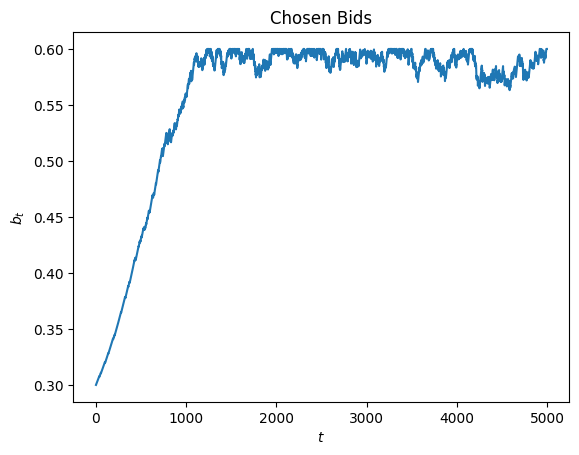

In [ ]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

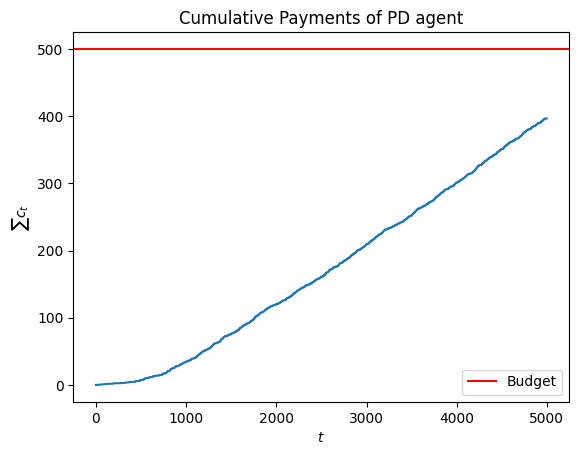

In [ ]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(params.budget, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of PD agent')
plt.show()

In [ ]:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    sorted_round_utility = np.flip(np.argsort(utility))
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [ ]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(params.budget, params.my_valuation, m_t, n_customers)

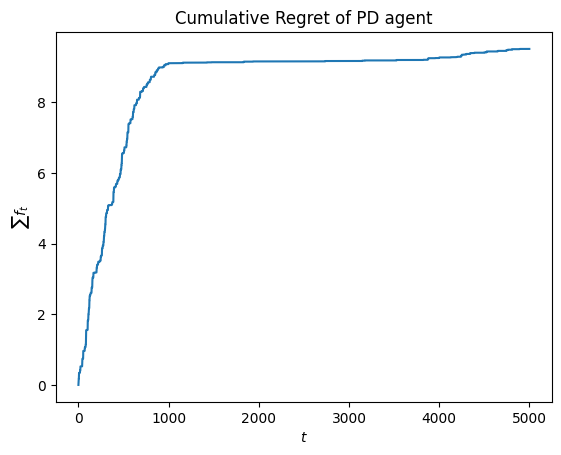

In [ ]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of PD agent')
plt.show()

## Agent: Pricing and Advertising (Primal Dual)

In [ ]:
class PrimalDualAgent:
    def __init__(self, valuation, budget, learning_rate_bidding, users, days, discretization_price, scale):
        #bidding
        self.valuation = valuation
        self.budget = budget
        self.learning_rate_bidding = learning_rate_bidding
        self.users = users
        self.rho = self.budget/self.users
        self.lmbd = 1

        #pricing
        self.available_price = np.linspace(0, 1, discretization_price)
        self.gp = RBFGaussianProcess(scale=scale).fit()
        self.price_ind = None
        self.price_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization_price)
        self.sigma_t = np.zeros(discretization_price)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5 * np.sqrt(2 * (self.gamma(t) + 1 + np.log(days)))

        self.N_price_pulls = np.zeros(discretization_price)
        self.day = 0
        self.days=days

    def set_price(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.available_price)
        ucbs = self.mu_t + self.beta(self.day) * self.sigma_t
        self.price_ind = np.argmax(ucbs)
        return self.available_price[self.price_ind]

    def update_pricing(self, r_t):
        self.N_price_pulls[self.price_ind] += 1
        self.price_hist = np.append(self.price_hist, self.available_price[self.price_ind])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.available_price[self.price_ind], r_t)
        self.day += 1

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update_bidding(self,c_t):
        self.lmbd = np.clip(self.lmbd-self.learning_rate_bidding*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [ ]:
params = ParametersReq1()
env = EnvironmentFull(users=params.users, ctrs= params.ctrs, conversion_probability=params.conversion_probability, cost = params.cost, prominence=1, budget = params.budget)
agent = PrimalDualAgent(valuation = params.my_valuation, budget = params.budget, learning_rate_bidding = params.learning_rate_bidding, users = params.users, days = params.days, discretization_price = params.discretization_price, scale = params.scale)

In [ ]:
reward_per_day = []
regret_bidding_per_day = []
users_per_day = []
available_price = np.linspace(0,1,params.discretization_price)

for day in range(params.days):
    agent.budget = params.budget
    agent.lmbd = 1

    price = agent.set_price()
    env.day(price)
    clairvoyant_bids_per_day, clairvoyant_utilities_per_day, clairvoyant_payments_per_day = get_clairvoyant_truthful(params.budget, params.my_valuation, env.m_t, params.users)


    reward_per_auction = []
    utilities_per_auction = []
    users_per_auction =0
    reward = 0

    for user in range(params.users):

        my_bid = agent.bid()
        winners, payments = env.auction(my_bid, user)
        my_win = int(winners==0)
        f_t, c_t = (params.my_valuation - env.m_t[user])*my_win, env.m_t[user]*my_win

        agent.update_bidding(c_t)

        r_t = 0
        if my_win:
            r_t = env.request()
            users_per_auction+=env.d_t

        reward += r_t
        reward_per_auction.append(reward)
        utilities_per_auction.append(f_t)


    regret_bidding_per_day.append(np.cumsum(clairvoyant_utilities_per_day-np.array(utilities_per_auction)))
    users_per_day.append(users_per_auction)
    reward_per_day.append(reward_per_auction[-1])

    agent.update_pricing(reward/params.users)

In [ ]:
avg_regret = np.array(regret_bidding_per_day).mean(axis=0)
std_regret = np.array(regret_bidding_per_day).std(axis=0)

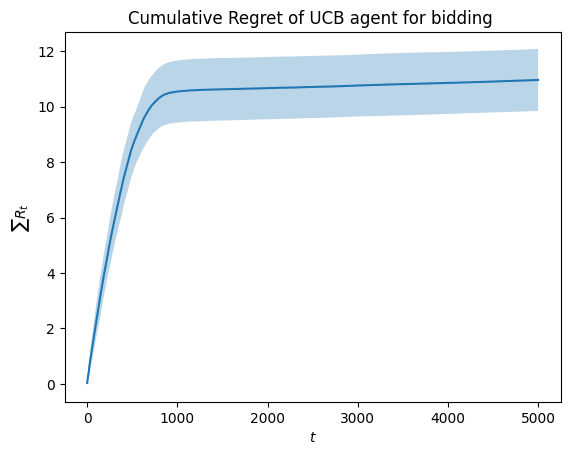

In [ ]:
plt.plot(np.arange(params.users), avg_regret)
plt.fill_between(range(params.users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB agent for bidding ')
plt.show()

In [ ]:
reward_function = lambda price, n_sales: (price-params.cost)*n_sales
# let's compute the clairvoyant
prices = np.linspace(0, 1, params.discretization_price)
profit_curve = reward_function(prices, params.users*params.conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = []
for u in users_per_day:
  expected_clairvoyant_rewards.append(reward_function(best_price,u))

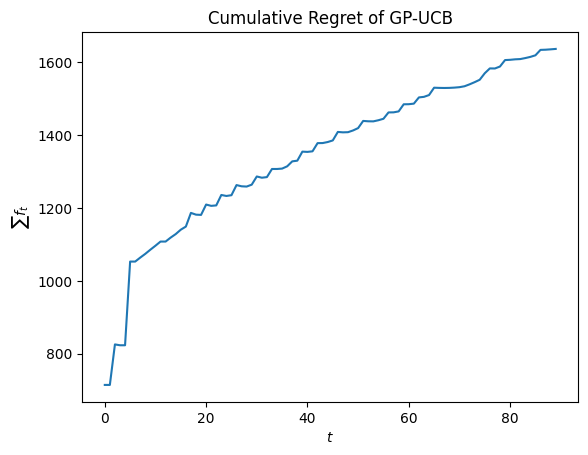

In [ ]:
cumulative_regret = np.cumsum(np.array(expected_clairvoyant_rewards)-np.array(reward_per_day))
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of GP-UCB')
plt.show()

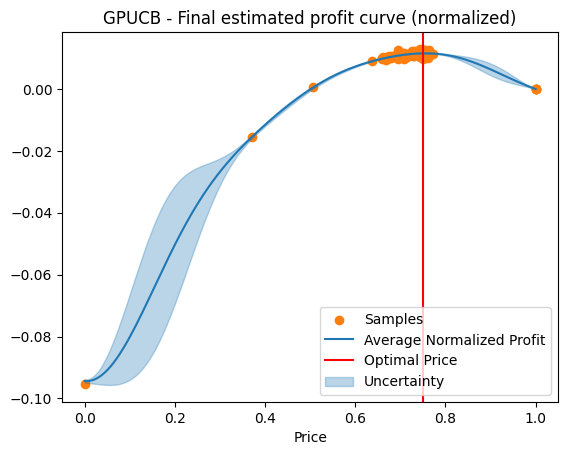

In [ ]:
profits = agent.reward_hist
prices = agent.price_hist
gp = RBFGaussianProcess(scale=20)
gp.fit(prices, profits)
mu, sigma = gp.predict(np.linspace(0,1,params.discretization_price))
sigma /= 20
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(np.linspace(0,1,params.discretization_price), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,params.discretization_price), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

---
# Requirement 2

In [ ]:
class ParametersReq2:
    ''' The class just implements the parameters of the algorithms '''
    def __init__(self):
        # pricing
        self.conversion_probability = lambda p : 1-p # It will corresponds to the price curve
        self.days = 90 #Number of days for our simulation of the pricing's campaign
        self.discretization_price = 1000 # number of sample in price grid
        self.learning_rate_pricing = 1/np.sqrt(self.days)
        self.cost = 0.5
        self.scale = 20

        # bidding
        self.users= 5000
        self.ctrs = np.array([1, 1, 1, 1])# Click-To-Rates Ratio for every advs
        self.my_valuation = 0.6 # It correponds to the true valuation of the item by the company,
        self.discretization_bid = 10
        self.budget = 500 #Budget of the advertiser
        self.learning_rate_bidding = 1/np.sqrt(self.users) # Learning rate for bidding's alg.
        self.n_advertisers = 4 #Number of advertisers
        self.range_f = 0.1 #Coefficient for the exploration term (ucbs) utility
        self.range_c = 0.1 #Coefficient for the exploration term (ucbs) cost



## Environment: bidding

In [ ]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def auction(self, bids):
        winners, values = self.get_winners(bids)
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


In [ ]:
class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots=n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        return winners, adv_values

    def get_payments_per_click(self, winners, bids):
        payments = bids[winners]
        return payments.round(2)

## Agent: bidding

In [ ]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(range(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [ ]:
class PrimalDualAgent_NonTruthful:
    def __init__(self, valuation, budget, users, learning_rate_bidding, discretization_bid):
        self.available_bid = np.linspace(0, 1, discretization_bid)
        self.discretization_bid = discretization_bid
        self.hedge = HedgeAgent(self.discretization_bid, np.sqrt(self.discretization_bid/users))
        self.valuation = valuation
        self.budget = budget
        self.learning_rate_bidding = learning_rate_bidding
        self.users = users
        self.rho = self.budget/self.users
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.available_bid[self.hedge.pull_arm()]

    def update_bidding(self, c_t, m_t):
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.available_bid])
        c_t_full = np.array([b*int(b >= m_t) for b in self.available_bid])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L)
        self.lmbd = np.clip(self.lmbd-self.learning_rate_bidding*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [ ]:
params = ParametersReq2()
other_bids = np.random.uniform(0, 1, size = (params.n_advertisers-1, params.users))
m_t = other_bids.max(axis=0)
masked_bids = np.where(other_bids == m_t, -np.inf, other_bids)
m2_t = masked_bids.max(axis=0)


In [ ]:
learning_rate_bidding = 1/np.sqrt(params.users) # from theory
agent = PrimalDualAgent_NonTruthful(valuation=params.my_valuation,
                                  budget=params.budget,
                                  learning_rate_bidding=learning_rate_bidding,
                                  users=params.users,
                                  discretization_bid=params.discretization_bid)

auction = GeneralizedFirstPriceAuction(params.ctrs,2)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(42)
for u in range(params.users):
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.auction(bids=bids)
    my_wins = np.where(winners == 0)[0]
    f_t=0
    c_t=0

    for win_slot in my_wins:
        payment = payments_per_click[win_slot]  # Payment per click for the slot
        utility = (params.my_valuation - payment)  # Utility for the slot
        f_t += utility
        c_t += payment

    agent.update_bidding(c_t, m_t[u])
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=len(my_wins)
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 919


In [ ]:
available_bids = np.linspace(0,1,params.discretization_bid)
win_probabilities = np.array([sum(b > m2_t)/params.users for b in available_bids])

rho=params.budget/params.users

c = -(params.my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for _ in range(params.users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for _ in range(params.users)]

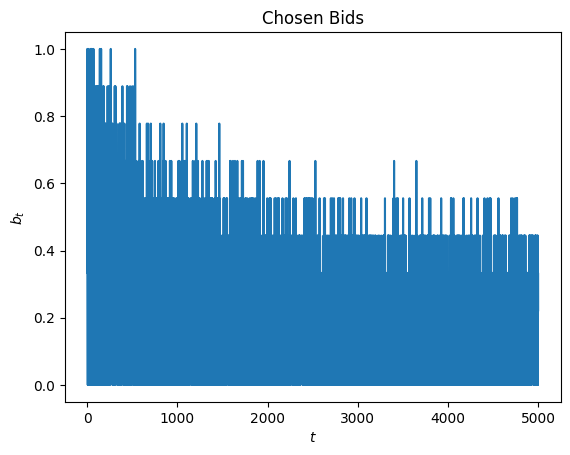

In [ ]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

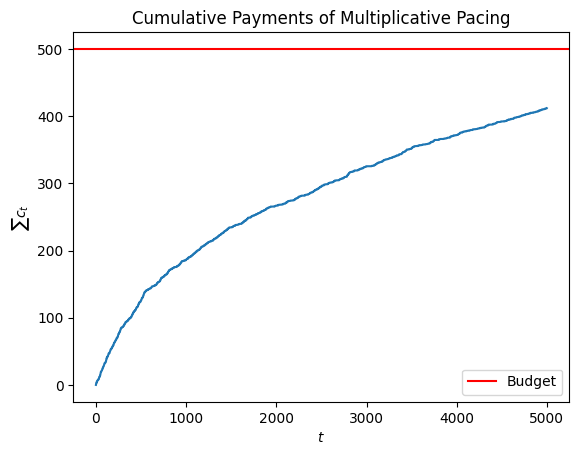

In [ ]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(params.budget, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

/tmp/ipykernel_21180/381404257.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.sqrt(range(params.users)*np.log(range(params.users))))
/tmp/ipykernel_21180/381404257.py:4: RuntimeWarning: invalid value encountered in multiply
  plt.plot(np.sqrt(range(params.users)*np.log(range(params.users))))


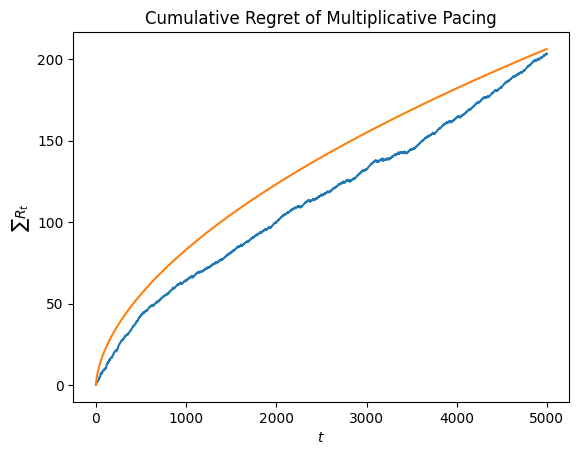

In [ ]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)

plt.plot(np.sqrt(range(params.users)*np.log(range(params.users))))
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

## Agent: Discrete Pricing (EXP 3)

In [ ]:
class DiscretePricingAgent:
    def __init__(self, discretization, learning_rate):
        self.learning_rate = learning_rate
        self.K = discretization
        self.weights = np.ones(self.K)
        self.x_t = np.ones(self.K)/self.K
        self.price_ind = None
        self.N_price_pulls = np.zeros(self.K)
        self.t = 0

    def set_price(self):
        self.x_t = self.weights/sum(self.weights)
        self.price_ind = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.price_ind

    def update_pricing(self, l_t):
        l_t_tilde = l_t/self.x_t[self.price_ind]
        self.weights[self.price_ind] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_price_pulls[self.price_ind] += 1
        self.t += 1

In [ ]:
class AdversarialBanditEnvironment:
    def __init__(self, loss_sequence):
        self.loss_sequence = loss_sequence
        self.t = 0

    def round(self, price_ind):
        l_t = self.loss_sequence[self.t, price_ind]
        self.t+=1
        return l_t

## Parameters

In [ ]:
class ParametersReq2b:
    ''' The class just implements the parameters of the algorithms '''
    def __init__(self):
        # pricing
        self.conversion_probability = lambda p : 1-p # It will corresponds to the price curve
        self.days = 900 #Number of days for our simulation of the pricing's campaign
        self.discretization_price = 3 # number of sample in price grid
        self.learning_rate_pricing = 1/np.sqrt(self.days)
        self.cost = 0.5
        self.scale = 20

        # bidding
        self.users= 5000
        self.ctrs = np.array([1, 1, 1, 1])# Click-To-Rates Ratio for every advs
        self.my_valuation = 0.6 # It correponds to the true valuation of the item by the company,
        self.discretization_bid = 10
        self.budget = 500 #Budget of the advertiser
        self.learning_rate_bidding = 1/np.sqrt(self.users) # Learning rate for bidding's alg.
        self.n_advertisers = 4 #Number of advertisers

        # both
        self.range_f = 0.1 #Coefficient for the exploration term (ucbs) utility
        self.range_c = 0.1 #Coefficient for the exploration term (ucbs) cost


In [ ]:
params = ParametersReq2b()

loss_seq = np.zeros((params.days, params.discretization_price))
np.random.seed(42)
P = [0.7, 0.5, 0.25]
for i in range(params.discretization_price):

    p = P[i]
    loss_seq[:,i] = np.random.binomial(n=1, p=p, size=params.days)

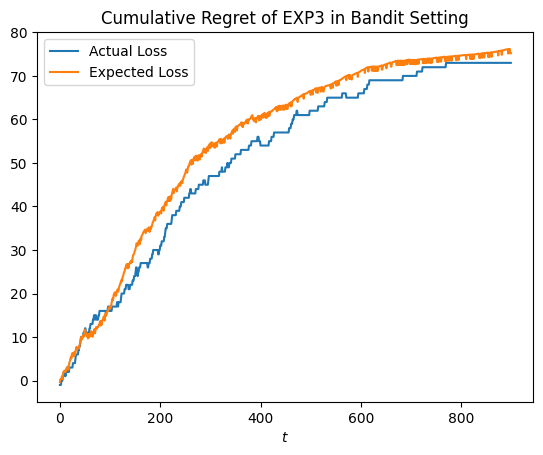

In [ ]:
learning_rate = np.sqrt(np.log(params.discretization_price)/(params.discretization_price*params.days))
agent = DiscretePricingAgent(params.discretization_price, learning_rate)
env = AdversarialBanditEnvironment(loss_seq)

best_arm = np.argmin(loss_seq.sum(axis=0))
clairvoyant_losses = loss_seq[:, best_arm]

agent_losses = np.array([])
expected_agent_losses = np.array([])
for t in range(params.days):
    price_ind = agent.set_price()
    l_t = env.round(price_ind)
    agent.update_pricing(l_t)
    # logging
    agent_losses = np.append(agent_losses, l_t)
    expected_agent_losses = np.append(expected_agent_losses,
                                    np.dot(agent.x_t,
                                           env.loss_sequence[t-1,:]))

plt.plot(np.cumsum(agent_losses-clairvoyant_losses), label='Actual Loss')
plt.plot(np.cumsum(expected_agent_losses-clairvoyant_losses), label='Expected Loss')
plt.title('Cumulative Regret of EXP3 in Bandit Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

## Environment: pricing and bidding

In [ ]:
class ParametersReq2:
    ''' The class just implements the parameters of the algorithms '''
    def __init__(self):
        # pricing
        self.conversion_probability = lambda p : 1-p # It will corresponds to the price curve
        self.days = 100 #Number of days for our simulation of the pricing's campaign
        self.discretization_price = 10 # number of sample in price grid
        self.learning_rate_pricing = 1/np.sqrt(self.days)
        self.cost = 0.5
        self.scale = 20

        # bidding
        self.users= 1500
        self.ctrs = np.array([1, 1, 1, 1])# Click-To-Rates Ratio for every advs
        self.my_valuation = 0.6 # It correponds to the true valuation of the item by the company,
        self.discretization_bid = 10
        self.budget = 150 #Budget of the advertiser
        self.learning_rate_bidding = 1/np.sqrt(self.users) # Learning rate for bidding's alg.
        self.n_advertisers = 4 #Number of advertisers

        # both
        self.range_f = 0.1 #Coefficient for the exploration term (ucbs) utility
        self.range_c = 0.1 #Coefficient for the exploration term (ucbs) cost


In [ ]:
class Environment2Full:
    def __init__(self, days, users, ctrs, cost, prominence, budget, num_slot = 1):
        self.days = days
        self.users = users
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs) -1
        self.num_slot = num_slot
        self.cost = cost
        self.reward = 0
        self.prominence = prominence
        self.budget = budget
        self.t = 0
        self.prob = 0
        self.conversion_probability = None
        self.d_t = 0
        self.R = np.linspace(1, 10, self.days)
        self.t = 0


    def day(self, price):
        self.reward = 0
        self.price = price
        r = self.R[self.t]
        self.conversion_probability = lambda p, r : 1-p*r/100
        self.prob = self.conversion_probability(self.price, r)
        mu_day = np.random.uniform(0, 1, size = (self.n_adv, 1))
        normal_values = np.random.normal(loc = mu_day , scale = 1, size = (self.n_adv, self.users))
        self.other_bids = 1 / (1 + np.exp(-normal_values))
        self.m_t = np.max(self.other_bids, axis = 0)
        masked_bids = np.where(self.other_bids == self.m_t, -np.inf, self.other_bids)
        self.m2_t = masked_bids.max(axis=0)
        self.t += 1

    def get_winners(self):
        adv_values = self.ctrs*self.bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.num_slot:]
        return winners, adv_values

    def get_payments_per_click(self, winners, bids):
        payments = bids[winners]
        return payments.round(2)

    def auction(self, my_bid, t):
        self.bids = np.append(my_bid, self.other_bids[:, t].ravel())
        winners, values = self.get_winners()
        payments_per_click = self.get_payments_per_click(winners, values)
        return winners, payments_per_click

    def request(self):
        x = np.random.binomial(1, self.prominence)
        if x != 0:
            self.d_t = np.random.binomial(1, self.prob)
        r_t = (self.price - self.cost) * self.d_t
        return r_t




## Agent pricing and bidding
Primal Dual with Hedge for bidding and EXP 3 for pricing  

In [ ]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [ ]:
class PrimalDualAgent_NonTruthfull_All:

  def __init__(self, valuation, budget, learning_rate_pricing, learning_rate_bidding, users, days, discretization_price, discretization_bid):
        # Bidding

        self.valuation = valuation
        self.budget = budget
        self.users= users
        self.rho = self.budget/self.users
        self.lmbd = 1
        self.auction = 0
        self.available_bids = np.linspace(0, 1, discretization_bid)
        self.N_bid_pulls = np.zeros(discretization_bid)
        self.bid_ind = None
        self.average_utilities = np.zeros(discretization_bid)
        self.average_costs = np.zeros(discretization_bid)
        self.Gamma = np.zeros(discretization_bid)
        self.learning_rate_bidding=learning_rate_bidding
        self.discretization_bid=discretization_bid
        self.hedge = HedgeAgent(self.discretization_bid, np.sqrt(np.log(self.discretization_bid)/users))


        # Pricing
        self.available_prices = np.linspace(0, 1, discretization_price)
        self.learning_rate_pricing = learning_rate_pricing
        self.days = days
        self.discretization_price = discretization_price
        self.weights = np.ones(self.discretization_price)
        self.x_t = np.ones(self.discretization_price)/self.discretization_price
        self.price_ind = None
        self.N_price_pulls = np.zeros(self.discretization_price)
        self.day = 0
        self.price_hist = np.array([])
        self.reward_hist = np.array([])


  def set_price(self):
        self.x_t = self.weights/sum(self.weights)
        self.price_ind = np.random.choice(range(self.discretization_price), p=self.x_t)
        return self.available_prices[self.price_ind]

  def update_pricing(self, l_t):
        l_t_tilde = l_t/self.x_t[self.price_ind]
        self.weights[self.price_ind] *= np.exp(-self.learning_rate_pricing*l_t_tilde)
        self.N_price_pulls[self.price_ind] += 1


  def bid(self):
        if self.budget < 1:
            return 0
        return self.available_bids[self.hedge.pull_arm()]

  def update_bidding(self, c_t, m_t):
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.available_bids])
        c_t_full = np.array([b*int(b >= m_t) for b in self.available_bids])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L)
        self.lmbd = np.clip(self.lmbd-self.learning_rate_bidding*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [ ]:
params = ParametersReq2()
learning_rate_pricing = np.sqrt(np.log(params.discretization_price)/(params.discretization_price*params.days))
env = Environment2Full(days= params.days,
                       users = params.users,
                       ctrs= params.ctrs,
                       cost = params.cost,
                       prominence=1,
                       budget = params.budget,
                       num_slot=2)
agent = PrimalDualAgent_NonTruthfull_All(days= params.days,
                                        valuation = params.my_valuation,
                                        budget = params.budget,
                                        learning_rate_pricing = learning_rate_pricing,
                                        learning_rate_bidding=params.learning_rate_bidding,
                                        users= params.users,
                                        discretization_price=params.discretization_price,
                                        discretization_bid=params.discretization_bid)

In [ ]:
reward_per_day = []
regret_bidding_per_day = []
price_per_day = []
users_per_day = []

available_bids = np.linspace(0, 1, params.discretization_bid)
for day in range(params.days):
    print('day',day)
    agent.budget = params.budget
    agent.auction = 0
    agent.lmbd = 1

    price = agent.set_price()
    price_per_day.append(price)
    env.day(price)
    win_probabilities=np.array([sum(b>env.m2_t)/params.users for b in available_bids])
    rho=params.budget/params.users

    c = -(params.my_valuation-available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = [-res.fun for _ in range(params.users)]
    expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for _ in range(params.users)]

    reward_per_auction = []
    utilities_per_auction = []
    users_per_auction = 0
    reward = 0

    for user in range(params.users):

        my_bid = agent.bid()
        winners, payments = env.auction(my_bid, user)
        my_wins = np.where(winners == 0)[0]
        f_t=0
        c_t=0

        for win_slot in my_wins:
          payment = payments[win_slot]
          utility = (params.my_valuation - payment)
          f_t += utility
          c_t += payment

        agent.update_bidding(c_t, env.m_t[user])
        r_t = 0
        for win_slot in my_wins:
            r_t = env.request()
            users_per_auction+=env.d_t

        reward += r_t
        reward_per_auction.append(r_t)
        utilities_per_auction.append(f_t)

    regret_bidding_per_day.append(np.cumsum(np.array(expected_clairvoyant_utilities)-np.array(utilities_per_auction)))
    users_per_day.append(users_per_auction)
    reward_per_day.append(reward)
    agent.update_pricing(1-reward/params.users)

day 0
day 1
day 2
day 3
day 4
day 5
day 6
day 7
day 8
day 9
day 10
day 11
day 12
day 13
day 14
day 15
day 16
day 17
day 18
day 19
day 20
day 21
day 22
day 23
day 24
day 25
day 26
day 27
day 28
day 29
day 30
day 31
day 32
day 33
day 34
day 35
day 36
day 37
day 38
day 39
day 40
day 41
day 42
day 43
day 44
day 45
day 46
day 47
day 48
day 49
day 50
day 51
day 52
day 53
day 54
day 55
day 56
day 57
day 58
day 59
day 60
day 61
day 62
day 63
day 64
day 65
day 66
day 67
day 68
day 69
day 70
day 71
day 72
day 73
day 74
day 75
day 76
day 77
day 78
day 79
day 80
day 81
day 82
day 83
day 84
day 85
day 86
day 87
day 88
day 89
day 90
day 91
day 92
day 93
day 94
day 95
day 96
day 97
day 98
day 99


In [ ]:
avg_regret = np.array(regret_bidding_per_day).mean(axis=0)
std_regret = np.array(regret_bidding_per_day).std(axis=0)

/tmp/ipykernel_21180/945605490.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.sqrt(range(params.users)*np.log(range(params.users))))
/tmp/ipykernel_21180/945605490.py:3: RuntimeWarning: invalid value encountered in multiply
  plt.plot(np.sqrt(range(params.users)*np.log(range(params.users))))


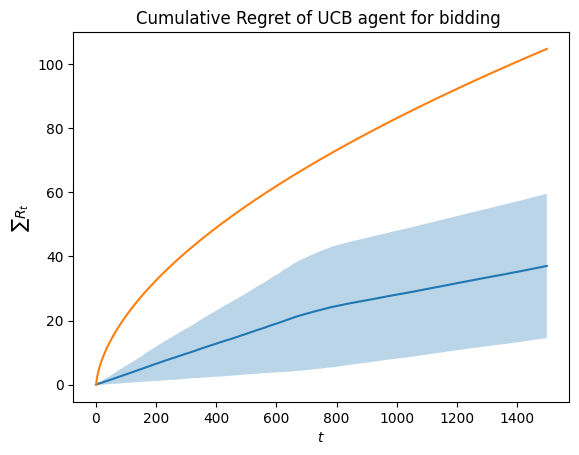

In [ ]:
plt.plot(np.arange(params.users), avg_regret)
plt.fill_between(np.arange(params.users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.plot(np.sqrt(range(params.users)*np.log(range(params.users))))
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB agent for bidding ')
plt.show()

In [ ]:
reward_function = lambda price, n_sales: (price-params.cost)*n_sales
# let's compute the clairvoyant
prices = np.linspace(0, 1, params.discretization_price)
profit_curve = reward_function(prices, params.users*params.conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = []
for u in users_per_day:
  expected_clairvoyant_rewards.append(reward_function(best_price,u))

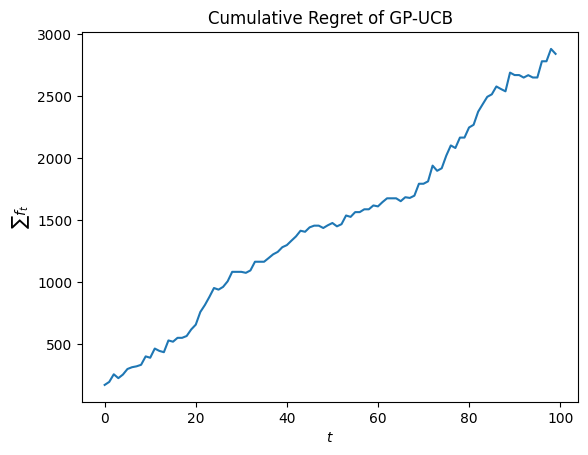

In [ ]:
cumulative_regret = np.cumsum(np.array(expected_clairvoyant_rewards)-np.array(reward_per_day))
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of GP-UCB')
plt.show()

---
# Requirement 3

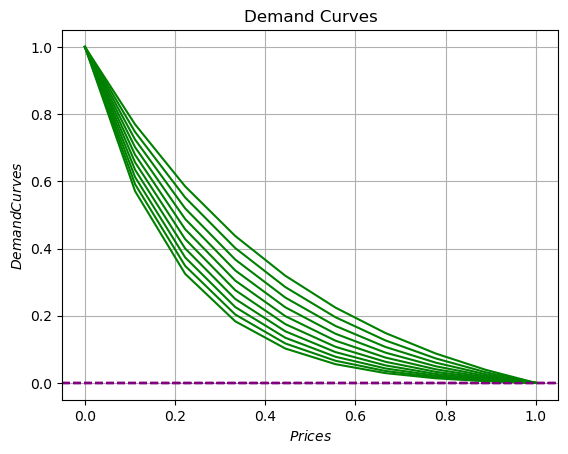

In [ ]:
conversion_probability = lambda r , p:  1 - (1 - np.exp(- r * p))/(1 - np.exp(-r))

prices = np.linspace(0, 1 , 10)
R = np.linspace(2, 5, 10)
for r in R:
    plt.plot(prices, conversion_probability(r , prices), 'g')
    plt.xlabel('$Prices$')
    plt.axhline(0, color='purple', linestyle='--', linewidth=1.5, label='Your Label')
    plt.ylabel('$Demand Curves$')
    plt.title('Demand Curves')
plt.grid()
plt.show()

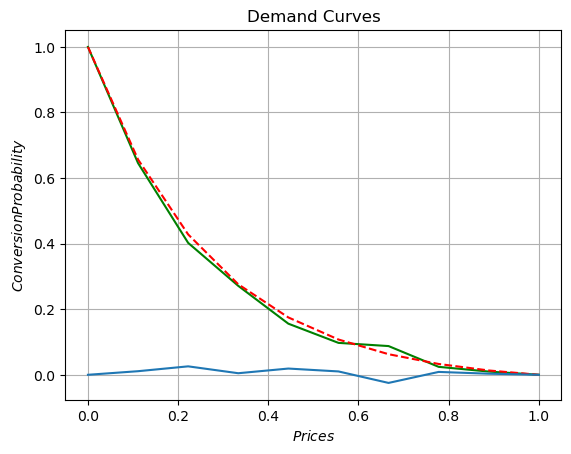

In [ ]:
R = np.linspace(2, 5, 10) #The number of angular coefficients will be are number of abrupt changes
prices  = np.linspace(0 , 1 , 10)
conversions_probabilities = []

mean = 0
std = 0.125**2
num_samples = 10


conversion_probability = lambda p , i:  1 - (1 - np.exp(- i * p))/(1 - np.exp(-i))

for i in R:
    samples = np.random.normal(mean, std, size=num_samples)
    samples[0] = 0
    samples[-1] = 0
    conversions_probabilities.append(conversion_probability(prices, i) + samples
)


whithout_noise_cp = lambda p , i:  1 - (1 - np.exp(- i * p))/(1 - np.exp(-i))
plt.plot(prices, conversions_probabilities[5], 'g')
plt.plot(prices, whithout_noise_cp(prices , i = R[6 - 1]), 'r--')
plt.plot(prices,  whithout_noise_cp(prices, i = R[6 - 1]) - conversions_probabilities[5] )
plt.xlabel('$Prices$')
#plt.axhline(0, color='purple', linestyle='--', linewidth=3, label='Your Label')
plt.ylabel('$Conversion Probability$')
plt.title('Demand Curves')
plt.grid()
plt.show()

 ## Perlin Noise Process

In [ ]:
# Function to generate Perlin noise based random noise
def perlin_noise(x, scale=2.5):
    return noise.pnoise1(x * scale)

prices  = np.linspace(0 , 1 , 10)
conversions_probabilities_perlin_noise = []
conversion_probability = lambda p , i: 1 - (1 - np.exp(- i * p))/(1 - np.exp(-i))
num_samples = 10
samples = np.zeros(num_samples)
for i in range(1 , num_samples-1):
    samples[i] =  0.1 * perlin_noise(random.random())

for i in R:
    conversions_probabilities_perlin_noise.append(conversion_probability(prices, i) + samples)


Parameter R: 3.6666666666666665


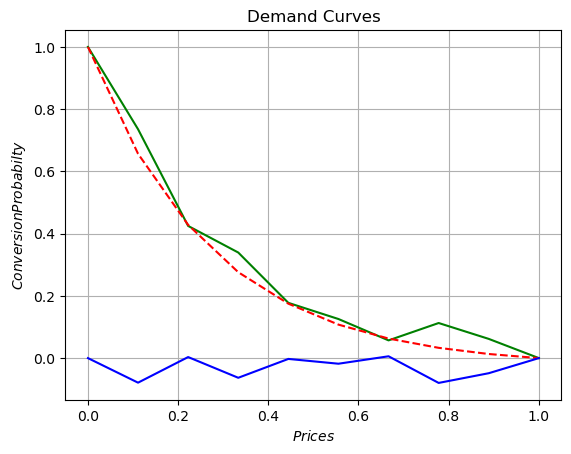

In [ ]:
print('Parameter R:', R[5])
plt.plot(prices, conversions_probabilities_perlin_noise[5], 'g')
plt.plot(prices, conversion_probability(prices, i = R[5]), 'r--')
plt.plot(prices,  conversion_probability(prices, i = R[5]) - conversions_probabilities_perlin_noise[5], 'b-')
plt.xlabel('$Prices$')
plt.ylabel('$Conversion Probabilty$')
plt.title('Demand Curves')
plt.grid()
plt.show()

## Confrontation

C:\Users\alfon\AppData\Local\Temp\ipykernel_12480\2283759189.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


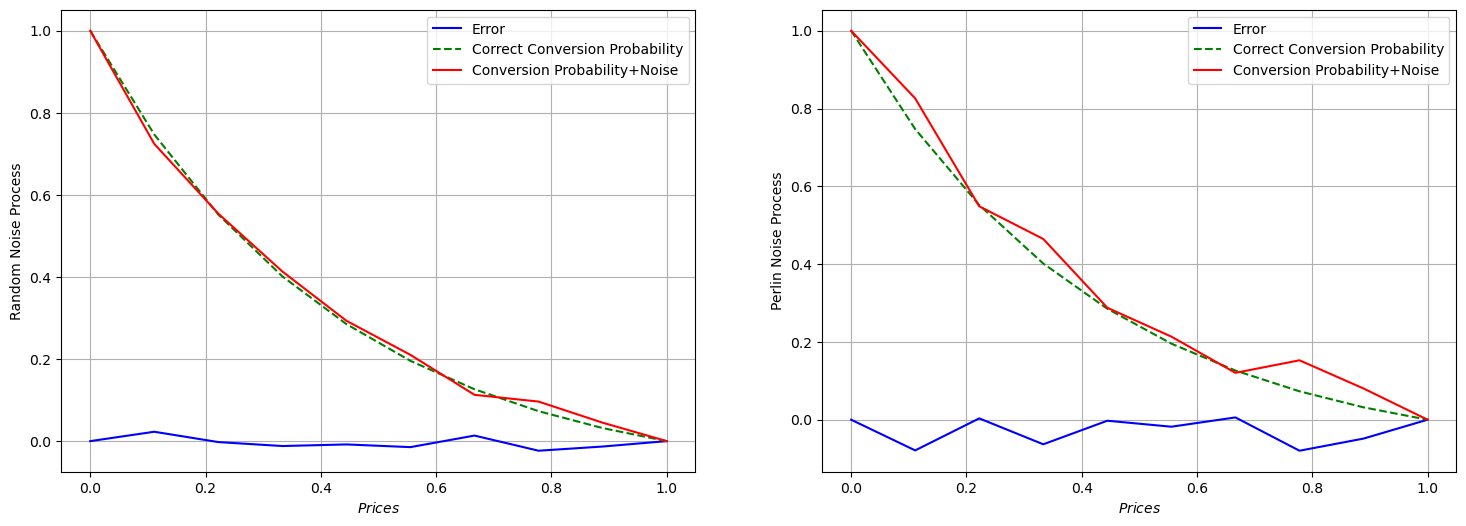

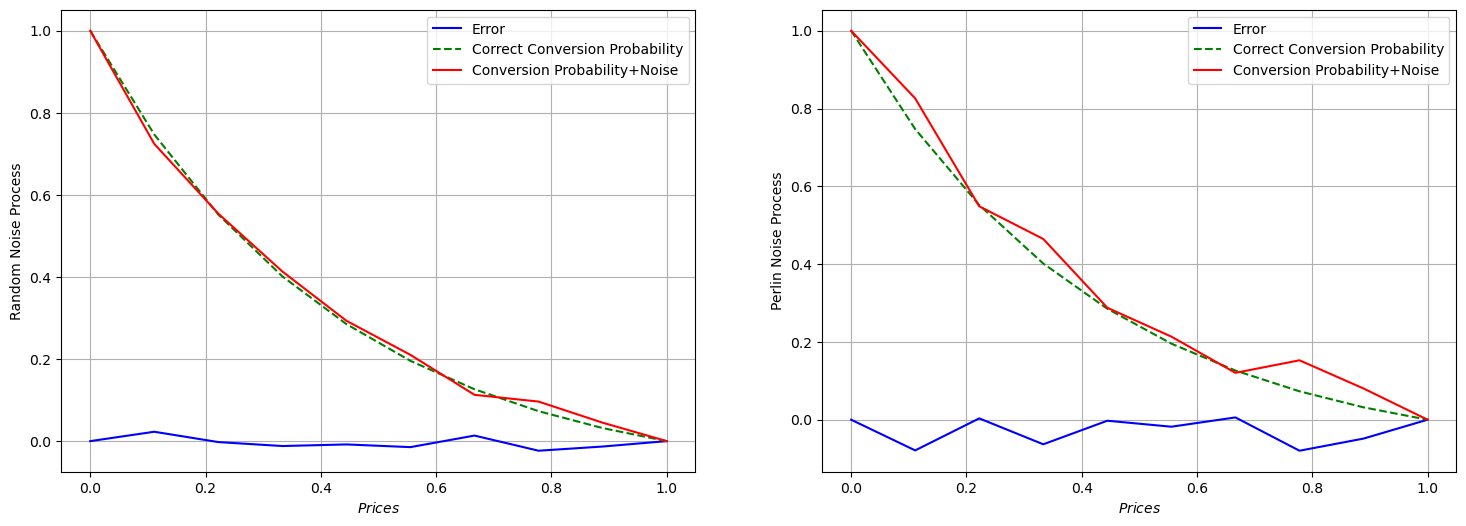

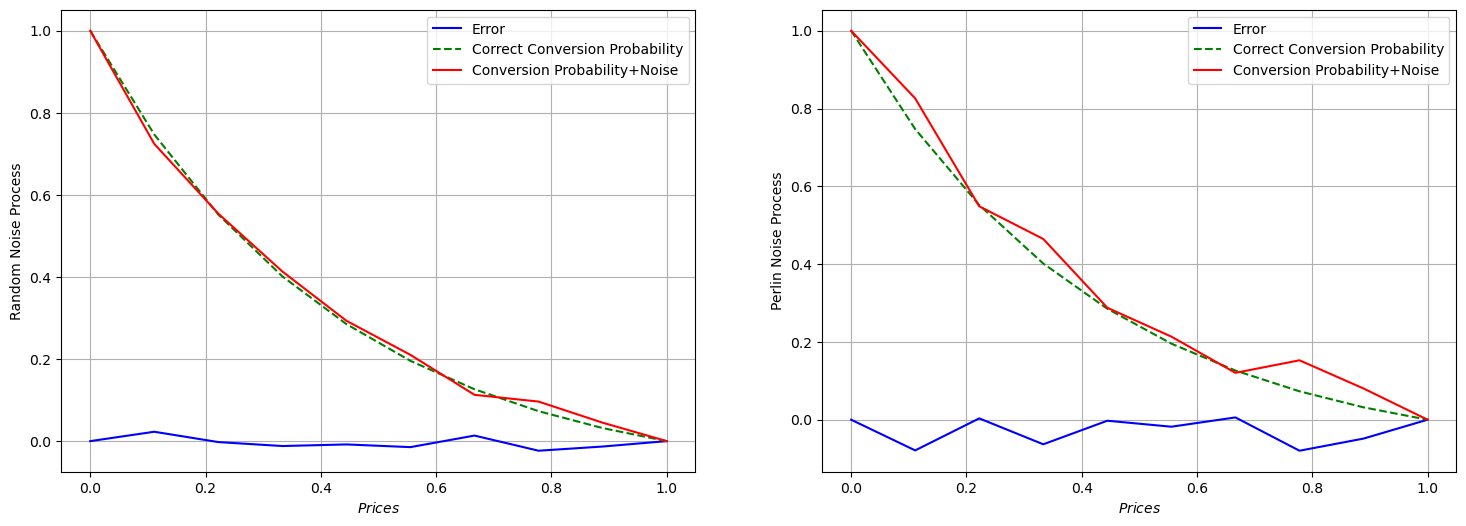

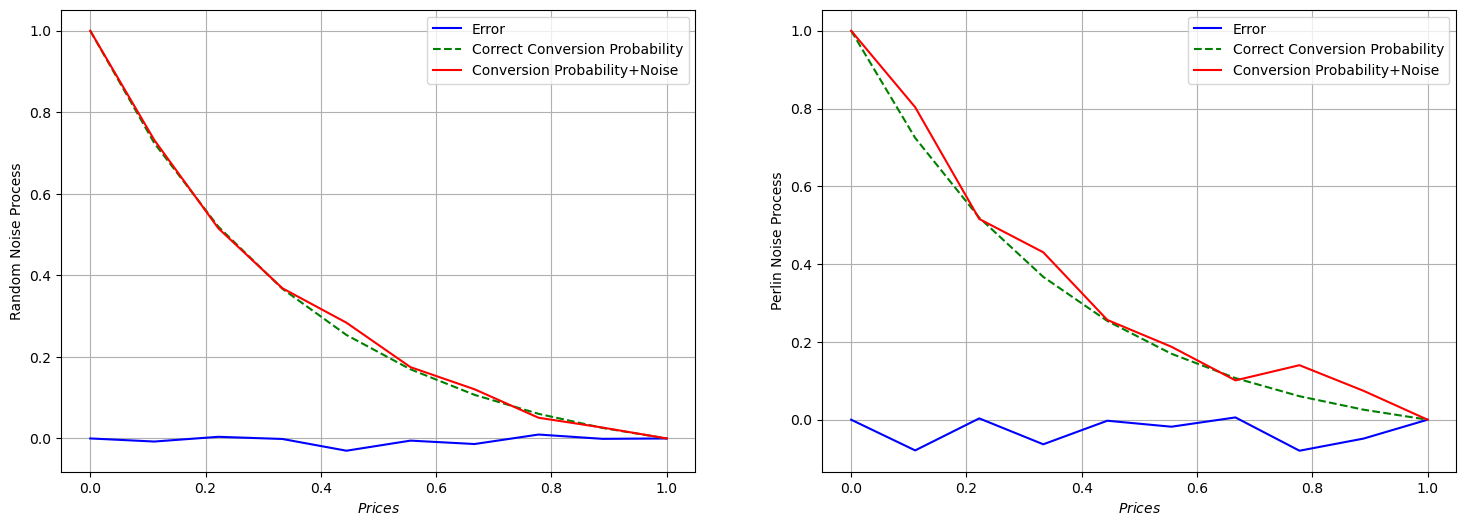

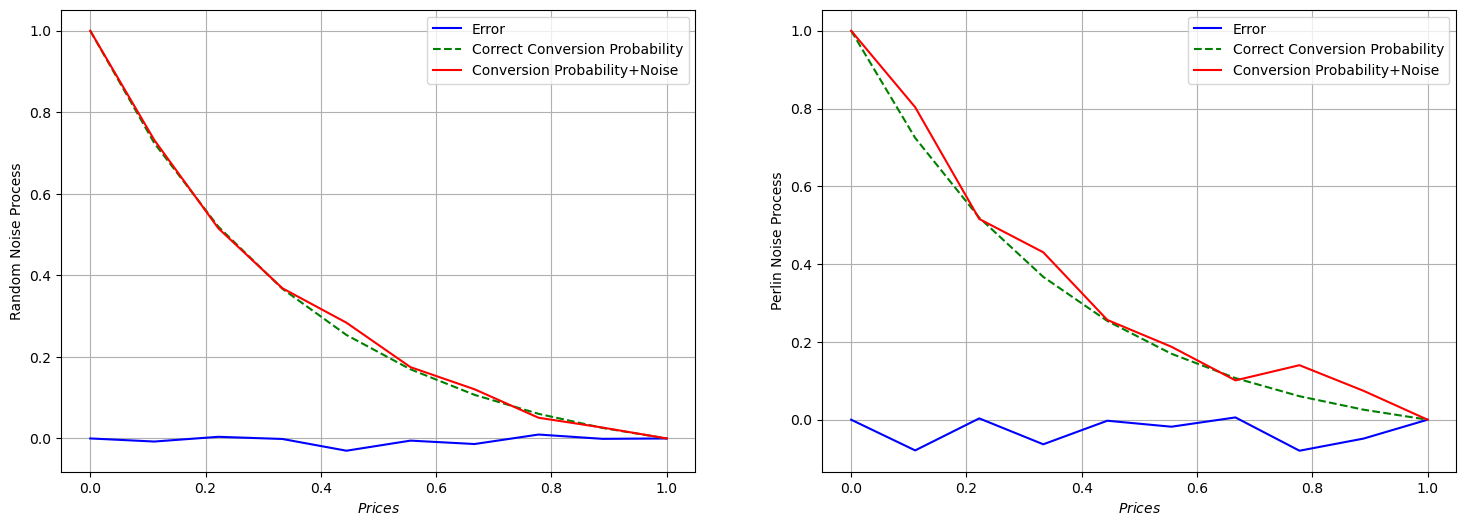

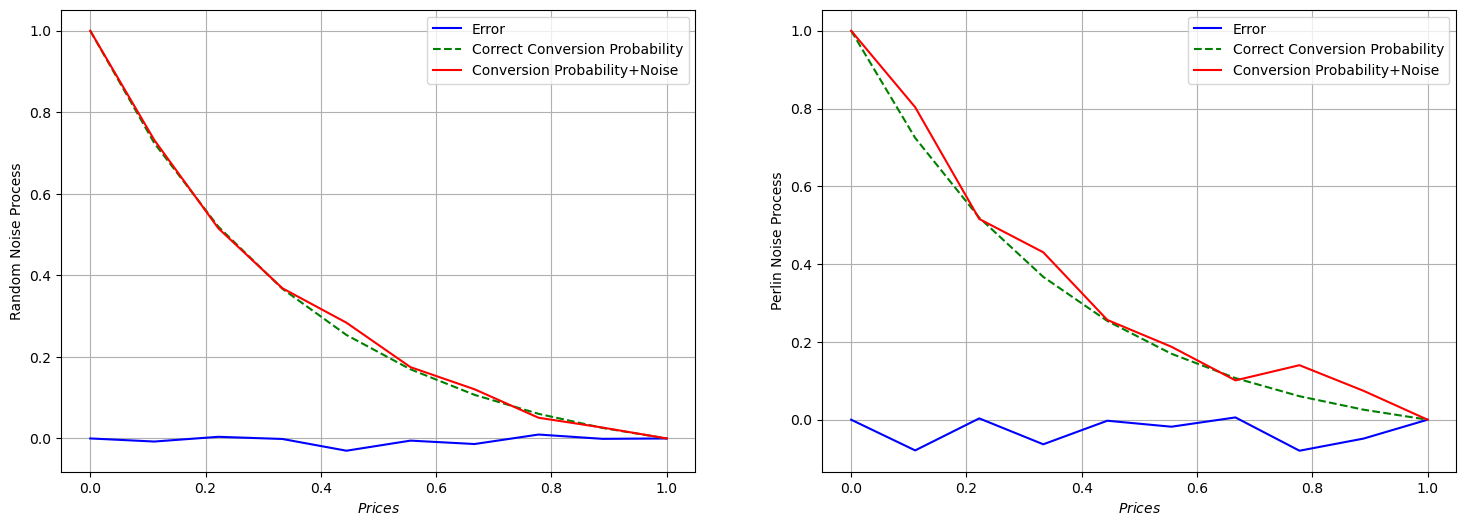

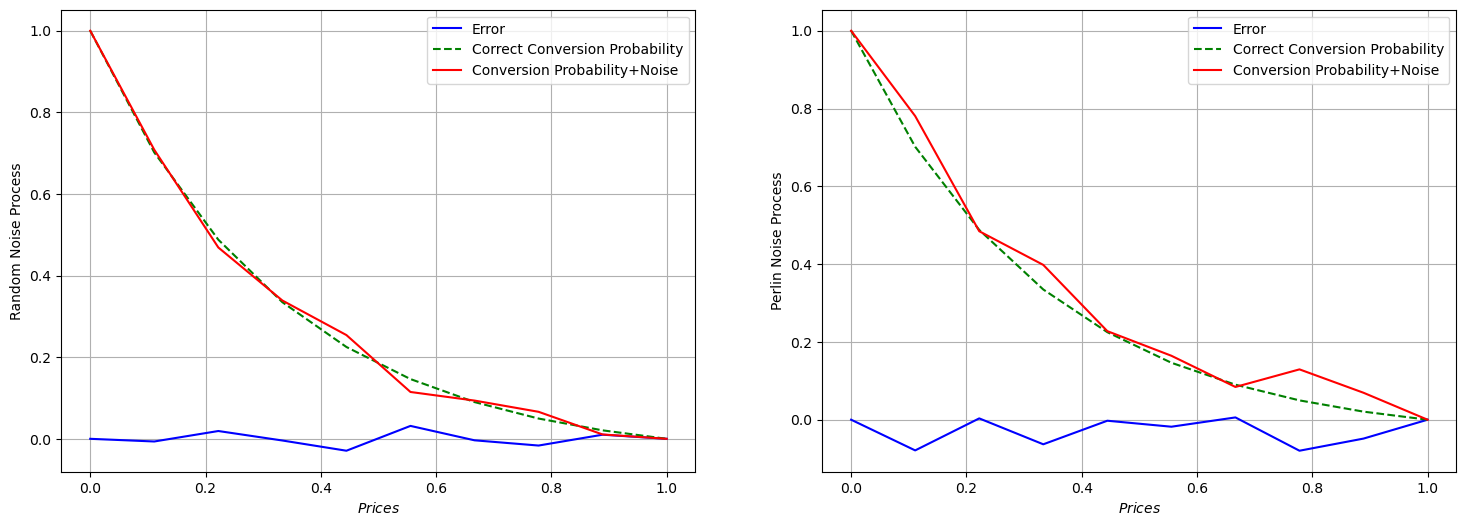

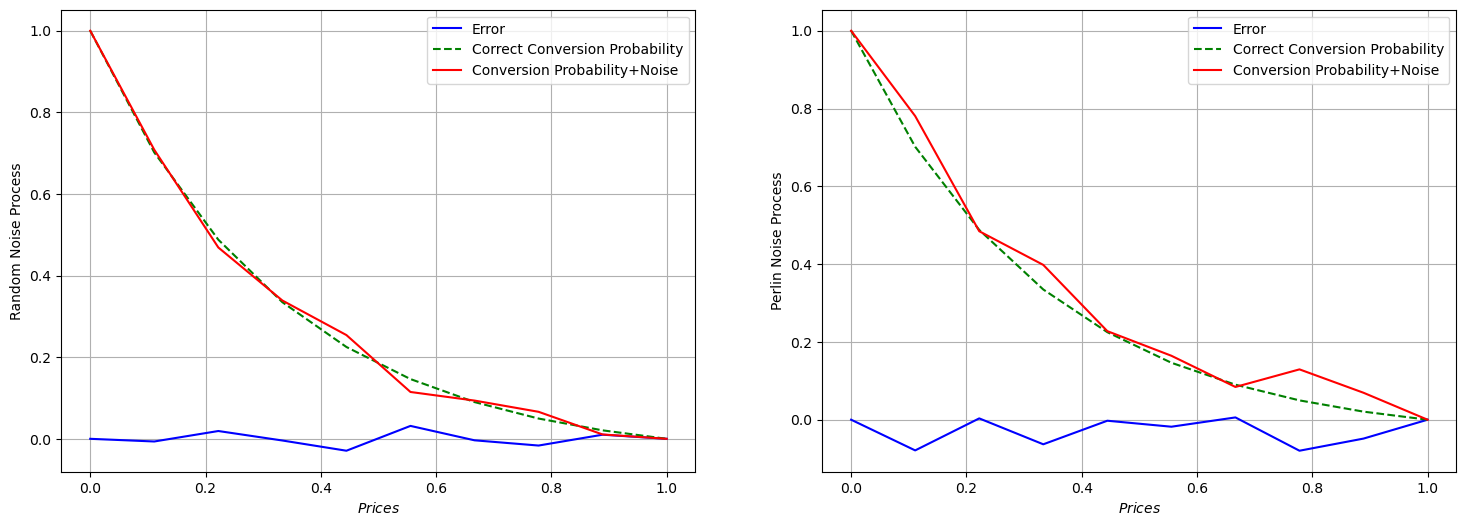

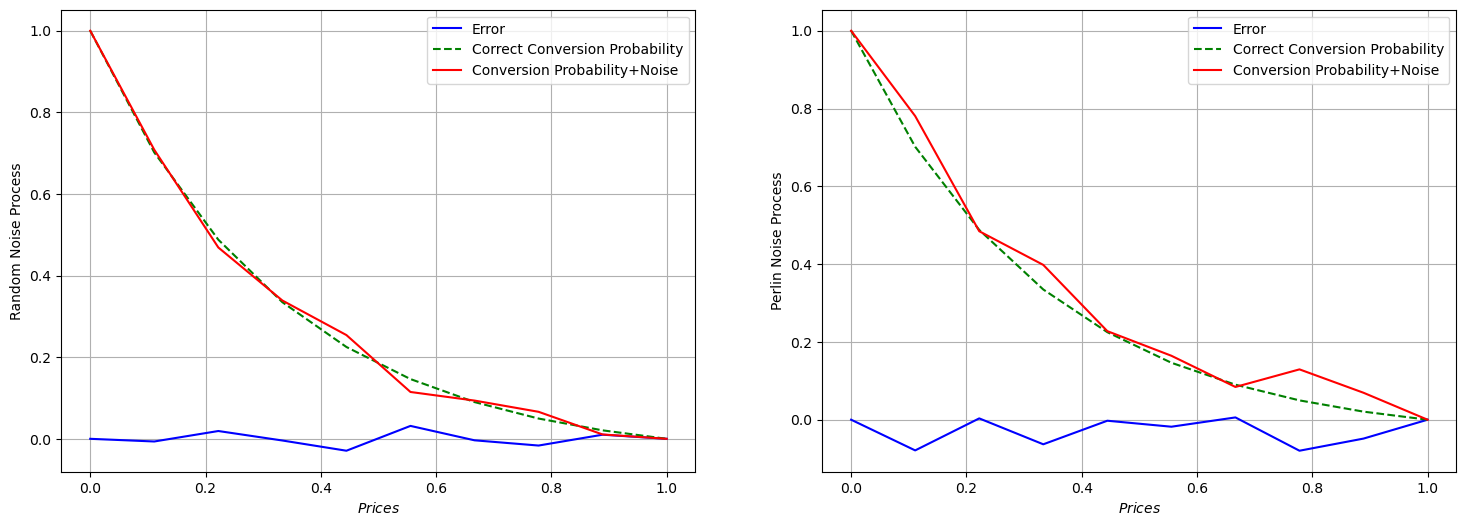

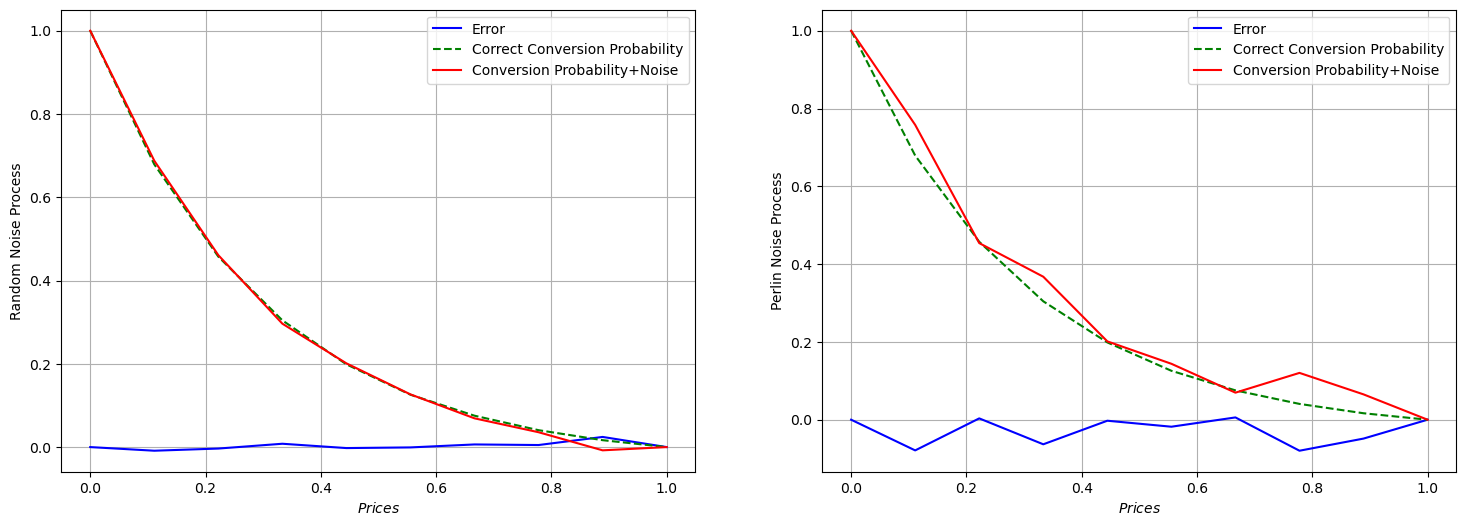

In [ ]:
for i in R:
    coeff = int(i)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
    ax1.plot(prices,  whithout_noise_cp(prices , i = R[coeff - 1]) - conversions_probabilities[coeff-1], 'b-')
    ax1.plot(prices, whithout_noise_cp(prices, i = R[coeff - 1]), 'g--')
    ax1.plot(prices,conversions_probabilities[coeff-1], 'r-')
    ax1.legend(['Error', 'Correct Conversion Probability', 'Conversion Probability+Noise'])
    ax1.set(xlabel = '$Prices$' , ylabel = 'Random Noise Process')
    ax1.grid()

    ax2.plot(prices,  whithout_noise_cp(prices, i = R[coeff - 1]) - conversions_probabilities_perlin_noise[coeff-1], 'b-')
    ax2.plot(prices, whithout_noise_cp(prices, i = R[coeff - 1]), 'g--')
    ax2.plot(prices,conversions_probabilities_perlin_noise[coeff-1], 'r-')

    ax2.legend(['Error', 'Correct Conversion Probability', 'Conversion Probability+Noise'])
    ax2.set(xlabel = '$Prices$' , ylabel = 'Perlin Noise Process')
    ax2.grid()

    fig.show()

In [ ]:
params = ParametersReq1()

Days = 5000 #Time horizon
K = 5#Number of intervals
arms = params.users#Number of arms, that will correspond to the number of rounds/users
break_points =(np.ceil(np.random.uniform(0, Days, K-1))) #


mu = []
for i in range(K):
    break_points = np.ceil(np.random.uniform(0, Days, K-1)).astype(int)
    mu_values = np.random.uniform(0, 1, K - 1)
    break_points = np.sort(break_points)

    # Preallocate the array
    mu_i = np.zeros(Days)

    # Assign values to mu_i based on break_points
    current_pos = 0
    for j in range(K-1):
        next_pos = current_pos + break_points[j]
        mu_i[current_pos:next_pos] = mu_values[j]
        current_pos = next_pos

    mu.append(mu_i)


---
## Abrupt Changes using the Conversion Probability Curve + Noise

In [ ]:
params = ParametersReq1()

Days = 5000 #Time horizon
K = 5#Number of intervals
# arms = params.users#Number of arms, that will correspond to the number of rounds/users
# set_of_angular_coeff
conversions_pbs = []
indexes = range(10)
#for i in range(K):
break_points = random.sample(range(5000), K-1)
indexes_conversion_pbs =random.sample(range(10), K-1)
break_points = np.sort(break_points)

# Preallocate the array
conversion_pb_i = np.zeros(Days)

# Assign values to mu_i based on break_points
current_pos = 0
for j in range(K-1):
    if j == 3:
        conversion_pb_i[current_pos:] = indexes_conversion_pbs[j]
    else:
        next_pos = break_points[j]
        conversion_pb_i[current_pos:next_pos] = indexes_conversion_pbs[j]
        current_pos = next_pos

conversions_pbs.append(conversion_pb_i)


In [ ]:
break_points

array([1012, 2545, 2905, 3263])

In [ ]:
indexes_conversion_pbs

[9, 6, 5, 7]

In [ ]:
conversions_pbs = np.array(conversions_pbs)
conversions_pbs

array([[9., 9., 9., ..., 7., 7., 7.]])

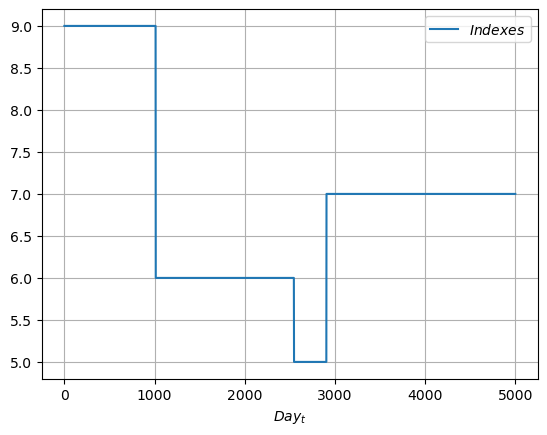

In [ ]:
t = np.arange(Days)
#for i in range(K):
plt.plot(t, conversions_pbs[0, :], label=f'$Indexes$')  # Correct label for each plot
plt.xlabel('$Day_{t}$')
plt.legend()
plt.grid()

plt.show()


C:\Users\alfon\AppData\Local\Temp\ipykernel_12480\2239217098.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


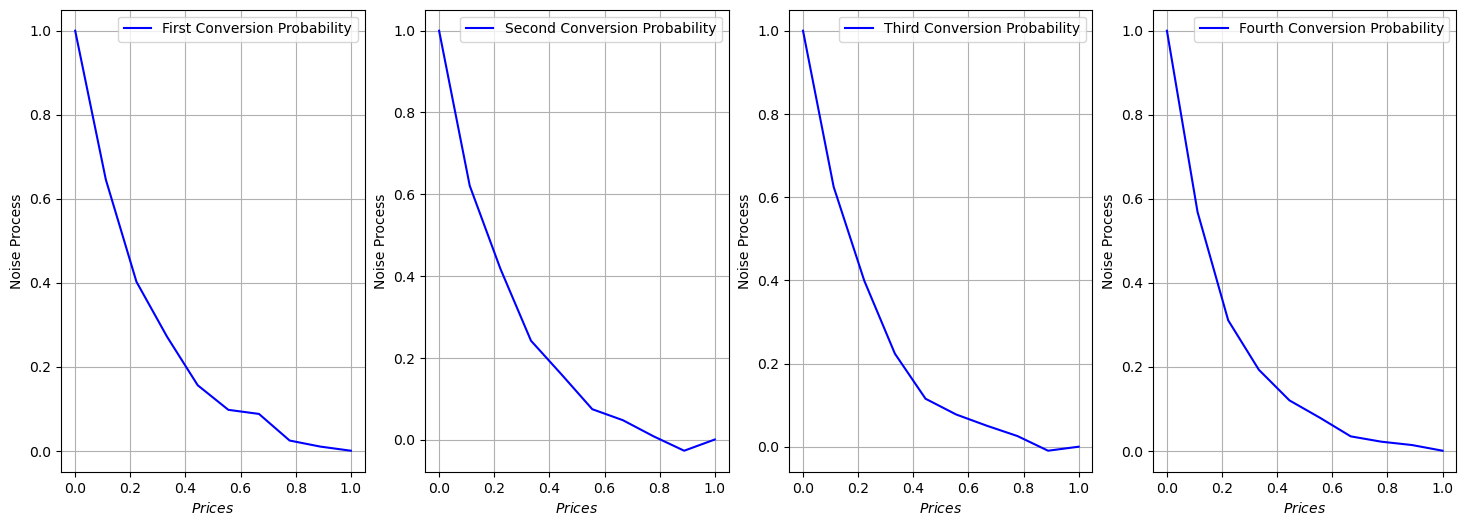

In [ ]:
from math import floor


fig, (ax1, ax2 , ax3, ax4) = plt.subplots(1, 4, figsize=(18,6))
ax1.plot(prices, conversions_probabilities[floor(np.unique(conversions_pbs)[0])] , 'b-')
ax1.legend(['First Conversion Probability'])
ax1.set(xlabel = '$Prices$' , ylabel = 'Noise Process')
ax1.grid()

ax2.plot(prices,conversions_probabilities[floor(np.unique(conversions_pbs)[1])]  , 'b-')
ax2.legend(['Second Conversion Probability'])
ax2.set(xlabel = '$Prices$' , ylabel = 'Noise Process')
ax2.grid()

ax3.plot(prices, conversions_probabilities[floor(np.unique(conversions_pbs)[2])] , 'b-')
ax3.legend(['Third Conversion Probability'])
ax3.set(xlabel = '$Prices$' , ylabel = 'Noise Process')
ax3.grid()

ax4.plot(prices, conversions_probabilities[floor(np.unique(conversions_pbs)[3])] , 'b-')
ax4.legend(['Fourth Conversion Probability'])
ax4.set(xlabel = '$Prices$' , ylabel = 'Noise Process')
ax4.grid()

fig.show()

In [ ]:
conversions_probabilities[floor(np.unique(conversions_pbs)[0])]

array([1.        , 0.64563444, 0.40233282, 0.2712938 , 0.15588096,
       0.09735581, 0.08761178, 0.02425195, 0.00985564, 0.        ])

In [ ]:
conversions_probabilities[floor(np.unique(conversions_pbs)[1])]
conversions_probabilities[floor(np.unique(conversions_pbs)[1])][8] = 0 #Where we notice negative values, we put them to zero

In [ ]:
conversions_probabilities[floor(np.unique(conversions_pbs)[2])]
conversions_probabilities[floor(np.unique(conversions_pbs)[2])][8] = 0 #Where we notice negative values, we put them to zero

In [ ]:
conversions_probabilities[floor(np.unique(conversions_pbs)[3])]

array([1.        , 0.56829116, 0.31053641, 0.19283644, 0.11982431,
       0.07827577, 0.03418223, 0.02149375, 0.01353199, 0.        ])

## Sliding Window Strategies - SW-UCB

In [ ]:
class ParameterReq3:
    ''' The class just implements the parameters of the algorithms '''
    def __init__(self):
        # pricing
        self.days = 10000 #Number of days for our simulation of the pricing's campaign
        self.discretization_price = 10 # number of sample in price grid
        self.K = 1
        self.U_T = 3

        # bidding
        self.users=50
        self.ctrs = np.array([1, 1, 1, 1])# Click-To-Rates Ratio for every advs
        self.my_valuation = 0.6 # It correponds to the true valuation of the item by the company,
        self.bid_range = np.linspace(0 , 1 , 10)# Discretization over the range of the bids ,
        self.scale = 15 #Scale of the distribution of the users
        self.B = 500 #Budget of the advertiser
        self.learning_rate_bidding = 1/np.sqrt(self.users) # Learning rate for bidding's alg.
        self.n_advertisers = 4 #Number of advertisers
        self.cost = 0.5
        #self.discretization_bid = 5 # number of sample in bidding grid

        # both
        self.range_f = 1 #Coefficient for the exploration term (ucbs) utility
        self.range_c = 1 #Coefficient for the exploration term (ucbs) cost



## SW-UCB

In [ ]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [ ]:
class Environment3Full:
    def __init__(self, days, users, ctrs, cost, prominence, budget, conversions_pbs,conversions_pbs_index, num_slot = 1):
        self.days = days
        self.conversions_pbs = conversions_pbs
        self.conversion_pbs_index = conversions_pbs_index
        self.users = users
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs) -1
        self.num_slot = num_slot
        self.cost = cost
        self.reward = 0
        self.prominence = prominence
        self.budget = budget
        self.t = 0
        self.prob = 0
        self.conversion_probability = None
        self.d_t = 0
        self.days = 0


    def day(self, price):
        self.reward = 0
        self.price = price
        self.conversion_probability = self.conversions_pbs[int(self.conversion_pbs_index[0 , self.days])]
        prices = np.linspace(0,1,params.discretization_price)
        ind = np.argwhere(prices == price)
        self.prob = self.conversion_probability[ind][0][0]
        mu_day = np.random.uniform(0, 1, size = (self.n_adv, 1))
        normal_values = np.random.normal(loc = mu_day , scale = 1, size = (self.n_adv, self.users))
        self.other_bids = 1 / (1 + np.exp(-normal_values))

        self.m_t = np.max(self.other_bids, axis = 0)
        self.days += 1

    def get_winners(self):
        adv_values = self.ctrs*self.bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.num_slot:]
        return winners, adv_values

    def get_payments_per_click(self, winners, bids):
        payments = bids[winners]
        return payments.round(2)

    def auction(self, my_bid, t):
        self.bids = np.append(my_bid, self.other_bids[:, t].ravel())
        winners, values = self.get_winners()
        payments_per_click = self.get_payments_per_click(winners, values)
        return winners, payments_per_click

    def request(self):
        x = np.random.binomial(1, self.prominence)
        if x != 0:
            self.d_t = np.random.binomial(1, self.prob)

        r_t = (self.price - self.cost) * self.d_t
        return r_t

    def request_loss(self, reward):
        return 1 - (reward + self.cost)/self.users

In [ ]:
class PrimalDualAgent_NonTruthfull_SW_UCB_All:
    def __init__(self, valuation, budget, learning_rate,eta_bid, users, days, bid_range, discretization_price,discretization_bid, W , K_SW , range):
        # Bidding

        self.valuation = valuation
        self.budget = budget
        self.users= users
        self.rho = self.budget/self.users
        self.lmbd = 1
        self.auction = 0
        self.bid_range = bid_range
        self.N_bid_pulls = np.zeros(len(bid_range))
        self.bid_ind = None
        self.average_utilities = np.zeros(len(bid_range))
        self.average_costs = np.zeros(len(bid_range))
        self.Gamma = np.zeros(len(bid_range))
        self.eta=eta_bid
        self.K_bid=discretization_bid
        self.hedge = HedgeAgent(self.K_bid, np.sqrt(np.log(self.K_bid)/users))


        # Pricing
        self.W = W
        self.K_SW = K_SW
        self.cache = np.repeat(np.nan, repeats=K_SW*W).reshape(W, K_SW)
        self.range = range
        self.learning_rate = learning_rate
        self.days = days
        self.learning_rate = learning_rate
        self.K_price = discretization_price
        self.weights = np.ones(self.K_price)
        self.x_t = np.ones(self.K_price)/self.K_price
        self.price_ind = None
        self.N_price_pulls = np.zeros(self.K_price)
        self.iter = 0
        self.price_hist = np.array([])
        self.reward_hist = np.array([])

    def set_price(self):

        if self.iter < min(self.K_SW, self.K_price):
            self.price_ind = self.iter
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            avg_last_w = np.nanmean(self.cache, axis=0)
            ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w)
            self.price_ind = np.argmax(ucbs)
        return self.price_ind

    def update_pricing(self, r_t):
        self.N_price_pulls[self.price_ind] += 1
        self.cache = np.delete(self.cache, (0), axis=0)
        new_samples = np.repeat(0, self.K_SW)
        new_samples[self.price_ind] = r_t
        self.cache = np.vstack((self.cache, new_samples))
        self.iter += 1

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bid_range[self.hedge.pull_arm()]

    def update_bidding(self, f_t,c_t,m_t):
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bid_range])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bid_range])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L)
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)

        self.budget-= c_t

In [ ]:
params = ParameterReq3()
learning_rate = np.sqrt(np.log(params.discretization_price)/(params.discretization_price*params.days))
W = int(2*np.sqrt(params.days*np.log(params.days)/params.U_T))

In [ ]:
params = ParameterReq3()
env = Environment3Full(days= params.days,users = params.users, ctrs= params.ctrs, cost = params.cost, prominence=1, budget = params.B,
                       conversions_pbs = conversions_probabilities ,conversions_pbs_index = conversions_pbs, num_slot=3)

agent = PrimalDualAgent_NonTruthfull_SW_UCB_All(days= params.days, valuation = params.my_valuation, budget = params.B, learning_rate = learning_rate,
                                                eta_bid=params.learning_rate_bidding,users= params.users, bid_range = params.bid_range,
                                                discretization_price=params.discretization_price,discretization_bid=len(params.bid_range), W = W  ,  K_SW = params.discretization_price, range= 1)

In [ ]:
price_range = np.linspace(0,1,params.discretization_price)

reward_per_day = []
regret_bidding_per_day = []
price_per_day = []

users_per_day = []
for day in np.arange(params.days):
    print('day',day)
    agent.budget = params.B
    agent.auction = 0
    agent.lmbd = 1
    price = price_range[agent.set_price()]
    print('Selected Price:', price)
    price_per_day.append(price)
    env.day(price)

    available_bids = params.bid_range

    win_probabilities=np.array([sum(b>env.m_t)/params.users for b in available_bids])


    rho=params.B/params.users
    ## Linear Program
    c = -(params.my_valuation-available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = [-res.fun for u in range(params.users)]
    expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(params.users)]


    reward_per_auction = []
    utilities_per_auction = []
    users_per_auction = 0
    reward = 0
    for user in np.arange(params.users):

        my_bid = agent.bid()
        winners, payments = env.auction(my_bid, user)
        my_wins = np.where(winners == 0)[0]
        f_t=0
        c_t=0

        for win_slot in my_wins:
          payment = payments[win_slot]
          utility = (params.my_valuation - payment)
          f_t += utility
          c_t += payment

        agent.update_bidding(f_t, c_t, env.m_t[user])

        r_t = 0
        for win_slot in my_wins:
            r_t = env.request()
            users_per_auction+=env.d_t

        reward += r_t *100
        reward_per_auction.append(r_t)
        utilities_per_auction.append(f_t)

    regret_bidding_per_day.append(np.cumsum(np.array(expected_clairvoyant_utilities)-np.array(utilities_per_auction)))
    users_per_day.append(users_per_auction)
    reward_per_day.append(reward)
    print('reward', reward)
    agent.update_pricing(reward)

In [ ]:
prices = np.linspace(0, 1, params.discretization_price)
expected_clairvoyant_rewards = []
indexes = indexes_conversion_pbs
bp = break_points
reward_function = lambda price, n_sales: (price-params.cost)*n_sales
j = 0

c_pbs = conversions_probabilities[indexes[0]]
profit_curve = reward_function(prices, params.users * c_pbs)
print(profit_curve)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
print('Best Price:', best_price)

for u in users_per_day[:bp[0]]:
    expected_clairvoyant_rewards.append(reward_function(best_price, u)*100)

for j in range(1, len(bp)):
    c_pbs = conversions_probabilities[indexes[j]]
    profit_curve = reward_function(prices, params.users * c_pbs)
    best_price_index = np.argmax(profit_curve)
    best_price = prices[best_price_index]
    print('Best Price:', best_price)

    for u in users_per_day[bp[j-1]:bp[j]]:
        expected_clairvoyant_rewards.append(reward_function(best_price, u)*100)

c_pbs = conversions_probabilities[indexes[-1]]
profit_curve = reward_function(prices, params.users * c_pbs)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
print('Best Price:', best_price)

for u in users_per_day[bp[-1]:]:
    expected_clairvoyant_rewards.append(reward_function(best_price, u)*100)


print(len(expected_clairvoyant_rewards))


[-25.         -11.05010583  -4.31300573  -1.60697031  -0.33284532
   0.2174327    0.28485193   0.29852432   0.26312196   0.        ]
Best Price: 0.7777777777777777
Best Price: 0.6666666666666666
Best Price: 0.6666666666666666
Best Price: 0.6666666666666666
Best Price: 0.6666666666666666
5000


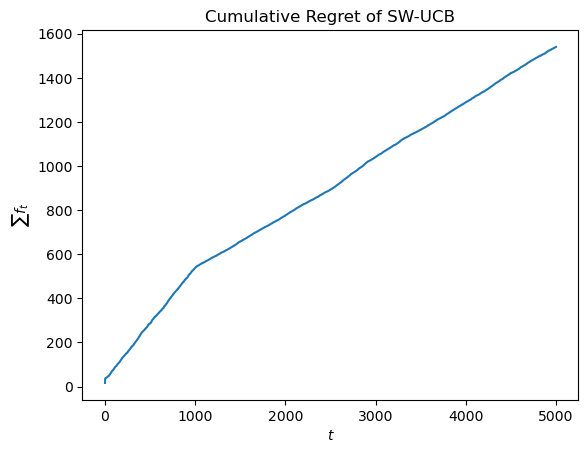

In [ ]:
cumulative_regret = np.cumsum((np.array(expected_clairvoyant_rewards)-np.array(reward_per_day))/100)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of SW-UCB')

plt.show()

---

## Change Detection Approaches - CUSUM-UCB


In [ ]:

class PrimalDualAgent_NonTruthfull_CUSUMUCB_All:
    def __init__(self, valuation, budget, learning_rate,eta_bid, users, days, bid_range, discretization_price,discretization_bid, M , K_CS, range, h , alpha = 0.99):
        # Bidding

        self.valuation = valuation
        self.budget = budget
        self.users= users
        self.rho = self.budget/self.users
        self.lmbd = 1
        self.auction = 0
        self.bid_range = bid_range
        self.N_bid_pulls = np.zeros(len(bid_range))
        self.bid_ind = None
        self.average_utilities = np.zeros(len(bid_range))
        self.average_costs = np.zeros(len(bid_range))
        self.Gamma = np.zeros(len(bid_range))
        self.eta=eta_bid
        self.K_bid=discretization_bid
        self.hedge = HedgeAgent(self.K_bid, np.sqrt(np.log(self.K_bid)/users))


        # Pricing
        self.days = days
        self.M = M
        self.K_CS = K_CS
        self.h = h
        self.alpha = alpha
        self.range = range
        self.price_ind = None
        self.reset_times = np.zeros(K_CS)
        self.counters = np.repeat(M, K_CS)
        self.average_rewards = np.zeros(K_CS)
        self.n_resets = np.zeros(K_CS)
        self.N_price_pulls = np.zeros(self.K_CS)
        self.all_rewards = [[] for _ in np.arange(K_CS)]


        self.learning_rate = learning_rate
        self.K_price = discretization_price
        self.weights = np.ones(self.K_price)
        self.x_t = np.ones(self.K_price)/self.K_price


        self.iter = 0
        self.n_t = 0
        self.price_hist = np.array([])
        self.reward_hist = np.array([])


    def set_price(self):
        if (self.counters > 0).any():
            for a in np.arange(self.K_CS):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.price_ind = a
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_price_pulls)
                self.price_ind = np.argmax(ucbs)
            else:
                self.price_ind = np.random.choice(np.arange(self.K_CS))
        return self.price_ind



    def update_pricing(self, r_t):
        self.N_price_pulls[self.price_ind] += 1
        self.all_rewards[self.price_ind].append(r_t)
        if self.counters[self.price_ind] == 0:
            if self.change_detection():
                self.n_resets[self.price_ind] +=1
                self.N_price_pulls[self.price_ind] = 0
                self.average_rewards[self.price_ind] = 0
                self.counters[self.price_ind] = self.M
                self.all_rewards[self.price_ind] = []
                self.reset_times[self.price_ind] = self.iter
            else:
                self.average_rewards[self.price_ind] += (r_t - self.average_rewards[self.price_ind])/self.N_price_pulls[self.price_ind]
        self.n_t = sum(self.N_price_pulls)
        self.iter += 1



    def change_detection(self):
        u_0 = np.mean(self.all_rewards[self.price_ind][:self.M])
        sp, sm = (np.array(self.all_rewards[self.price_ind][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.price_ind][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False


    def bid(self):
        if self.budget < 1:
            return 0
        return self.bid_range[self.hedge.pull_arm()]

    def update_bidding(self, f_t,c_t,m_t):
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bid_range])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bid_range])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L)

        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)

        self.budget -= c_t

In [ ]:

params = ParameterReq3()

U_T = 3 # maximum number of abrupt changes
h = 2*np.log(params.days/U_T) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T*np.log(params.days/U_T)/params.days) # probability of extra exploration

M = int(np.log(params.days/U_T)) # robustness of change detection

env = Environment3Full(days= params.days,users = params.users, ctrs= params.ctrs, cost = params.cost, prominence=1, budget = params.B,
                       conversions_pbs = conversions_probabilities ,conversions_pbs_index = conversions_pbs, num_slot=3)

agent = PrimalDualAgent_NonTruthfull_CUSUMUCB_All(days= params.days, valuation = params.my_valuation, budget = params.B, learning_rate = learning_rate,
                                                eta_bid=params.learning_rate_bidding,users= params.users, bid_range = params.bid_range,
                                                discretization_price=params.discretization_price,discretization_bid=len(params.bid_range), M = M  ,  K_CS = 10 , range = 1, h = h , alpha = alpha )

In [ ]:
price_range = np.linspace(0,1,params.discretization_price)

reward_per_day = []
regret_bidding_per_day = []
price_per_day = []

users_per_day = []
for day in np.arange(params.days):
    print('day',day)
    agent.budget = params.B
    agent.auction = 0
    agent.lmbd = 1


    price = price_range[agent.set_price()]
    print('Selected Price:', price)
    price_per_day.append(price)
    env.day(price)
    available_bids = params.bid_range

    win_probabilities=np.array([sum(b>env.m_t)/params.users for b in available_bids])

    rho=params.B/params.users
    ## Linear Program
    c = -(params.my_valuation-available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = [-res.fun for u in range(params.users)]
    expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(params.users)]

    reward_per_auction = []
    utilities_per_auction = []
    users_per_auction = 0
    reward = 0
    for user in np.arange(params.users):

        my_bid = agent.bid()
        winners, payments = env.auction(my_bid, user)
        my_wins = np.where(winners == 0)[0]
        f_t=0
        c_t=0

        for win_slot in my_wins:
          payment = payments[win_slot]
          utility = (params.my_valuation - payment)
          f_t += utility
          c_t += payment

        agent.update_bidding(f_t, c_t, env.m_t[user])

        r_t = 0
        for win_slot in my_wins:
            r_t = env.request()
            users_per_auction+=env.d_t

        reward += r_t *100
        reward_per_auction.append(r_t)
        utilities_per_auction.append(f_t)

    regret_bidding_per_day.append(np.cumsum(np.array(expected_clairvoyant_utilities)-np.array(utilities_per_auction)))
    users_per_day.append(users_per_auction)
    reward_per_day.append(reward)
    print('reward', reward)
    agent.update_pricing(reward)

day 0
Selected Price: 0.0
reward -1450.0
day 1
Selected Price: 0.0
reward -850.0
day 2
Selected Price: 0.0
reward -900.0
day 3
Selected Price: 0.0
reward -1100.0
day 4
Selected Price: 0.0
reward -1100.0
day 5
Selected Price: 0.0
reward -900.0
day 6
Selected Price: 0.0
reward -700.0
day 7
Selected Price: 0.0
reward -800.0
day 8
Selected Price: 0.1111111111111111
reward -466.6666666666668
day 9
Selected Price: 0.1111111111111111
reward -388.88888888888897
day 10
Selected Price: 0.1111111111111111
reward -583.3333333333335
day 11
Selected Price: 0.1111111111111111
reward -505.5555555555557
day 12
Selected Price: 0.1111111111111111
reward -272.22222222222223
day 13
Selected Price: 0.1111111111111111
reward -194.44444444444446
day 14
Selected Price: 0.1111111111111111
reward -350.00000000000006
day 15
Selected Price: 0.1111111111111111
reward -583.3333333333335
day 16
Selected Price: 0.2222222222222222
reward -111.11111111111111
day 17
Selected Price: 0.2222222222222222
reward -138.88888888

IndexError: index 5000 is out of bounds for axis 1 with size 5000

In [ ]:
prices = np.linspace(0, 1, params.discretization_price)
expected_clairvoyant_rewards = []
indexes = indexes_conversion_pbs
bp = break_points
reward_function = lambda price, n_sales: (price-params.cost)*n_sales
j = 0

# Primo intervallo: da 0 fino a bp[0]
c_pbs = conversions_probabilities[indexes[0]]
profit_curve = reward_function(prices, params.users * c_pbs)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]

for u in users_per_day[:bp[0]]:  # da 0 a bp[0]
    expected_clairvoyant_rewards.append(reward_function(best_price, u)*100)

# Intervalli intermedi: da bp[j-1] a bp[j] per j=1,2
for j in range(1, len(bp)):
    c_pbs = conversions_probabilities[indexes[j]]
    profit_curve = reward_function(prices, params.users * c_pbs)
    best_price_index = np.argmax(profit_curve)
    best_price = prices[best_price_index]

    # Itera sugli utenti da bp[j-1] a bp[j]
    for u in users_per_day[bp[j-1]:bp[j]]:
        expected_clairvoyant_rewards.append(reward_function(best_price, u)*100)

# Ultimo intervallo: da bp[-1] fino alla fine
c_pbs = conversions_probabilities[indexes[-1]]
profit_curve = reward_function(prices, params.users * c_pbs)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]

for u in users_per_day[bp[-1]:]:  # da bp[3] fino alla fine di users_per_day
    expected_clairvoyant_rewards.append(reward_function(best_price, u)*100)

# Controlliamo la lunghezza finale di expected_clairvoyant_rewards
print(len(expected_clairvoyant_rewards))


5000


In [ ]:
print((expected_clairvoyant_rewards))
print((reward_per_day))

[805.5555555555553, 472.22222222222206, 499.99999999999983, 611.1111111111109, 611.1111111111109, 499.99999999999983, 388.88888888888874, 444.4444444444443, 333.3333333333332, 277.77777777777766, 416.6666666666665, 361.111111111111, 194.44444444444437, 138.88888888888883, 249.99999999999991, 416.6666666666665, 111.11111111111107, 138.88888888888883, 138.88888888888883, 277.77777777777766, 194.44444444444437, 138.88888888888883, 222.22222222222214, 222.22222222222214, 27.777777777777768, 83.3333333333333, 138.88888888888883, 0.0, 111.11111111111107, 111.11111111111107, 83.3333333333333, 138.88888888888883, 0.0, 55.555555555555536, 27.777777777777768, 55.555555555555536, 138.88888888888883, 0.0, 55.555555555555536, 111.11111111111107, 83.3333333333333, 0.0, 27.777777777777768, 83.3333333333333, 138.88888888888883, 83.3333333333333, 111.11111111111107, 83.3333333333333, 27.777777777777768, 111.11111111111107, 27.777777777777768, 27.777777777777768, 27.777777777777768, 0.0, 55.555555555555

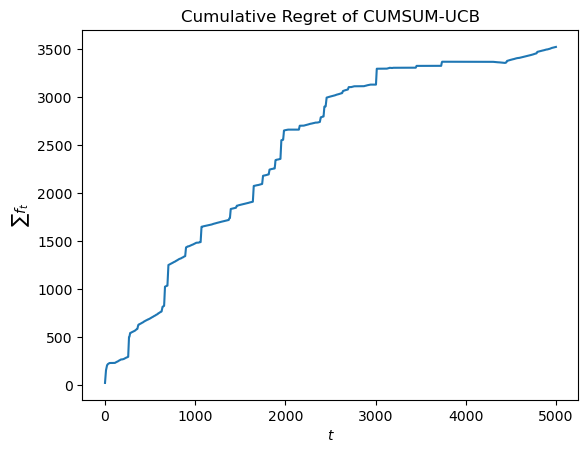

In [ ]:
cumulative_regret = np.cumsum((np.array(expected_clairvoyant_rewards)-np.array(reward_per_day))/100)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of CUMSUM-UCB')

plt.show()

# Requirement 4

### Environment: Generalized first price auction

In [4]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def auction(self, bids):
        winners, values = self.get_winners(bids)
        payments_per_click = self.get_payments_per_click(winners, bids)
        return winners, payments_per_click


In [5]:
class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots=n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_slots:]
        return winners, adv_values

    def get_payments_per_click(self, winners, bids):
        payments = [bids[i] for i in winners]
        return payments

### Agent1: PD for truthful

In [6]:
class AGENT_1:
    def __init__(self, valuation, budget, learning_rate_bidding, users):
        self.valuation = valuation
        self.budget = budget
        self.learning_rate_bidding = learning_rate_bidding # learning rate
        self.users = users
        self.rho = self.budget/self.users
        self.lmbd = 1

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update_bidding(self, c_t):
        self.lmbd = np.clip(self.lmbd-self.learning_rate_bidding*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t


### Agent2: PD for non truthful

In [7]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(range(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [8]:
class AGENT_2:
    def __init__(self, valuation, budget, users, learning_rate_bidding, discretization_bid):
        self.available_bid = np.linspace(0, 1, discretization_bid)
        self.discretization_bid = discretization_bid
        self.hedge = HedgeAgent(self.discretization_bid, np.sqrt(np.log(self.discretization_bid)/users))
        self.valuation = valuation
        self.budget = budget
        self.learning_rate_bidding = learning_rate_bidding
        self.users = users
        self.rho = self.budget/self.users
        self.lmbd = 0
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.available_bid[self.hedge.pull_arm()]

    def update_bidding(self, c_t, m_t):
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.available_bid])
        c_t_full = np.array([b*int(b >= m_t) for b in self.available_bid])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L)
        self.lmbd = np.clip(self.lmbd-self.learning_rate_bidding*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

### Agent3: UCB-like

In [9]:
class AGENT_3:
    def __init__(self, budget, users, range_f, range_c, discretization_bid):
        self.discretization_bid = discretization_bid
        self.available_bids = np.linspace(0,1,discretization_bid)
        self.N_bid_pulls = np.zeros(discretization_bid)
        self.budget = budget
        self.users = users
        self.rho = self.budget/self.users
        self.auction = 0
        self.range_f = range_f
        self.range_c = range_c
        self.bid_ind = None

        self.average_utilities = np.zeros(discretization_bid)
        self.average_costs = np.zeros(discretization_bid)
        self.Gamma = np.zeros(discretization_bid)

    def bid(self):
        if self.budget < 1:
          self.bid_ind = 0
          return self.bid_ind
        else:
            if self.auction < self.discretization_bid:
                self.bid_ind = self.auction
            else:
                self.bid_ind = np.random.choice(a = range(self.discretization_bid), p=self.Gamma.x)
            return self.available_bids[int(self.bid_ind)]

    def update_bidding(self, f_t, c_t):
        self.N_bid_pulls[self.bid_ind] += 1
        self.average_utilities[self.bid_ind] += (f_t - self.average_utilities[self.bid_ind])/self.N_bid_pulls[self.bid_ind]
        self.average_costs[self.bid_ind] += (c_t - self.average_costs[self.bid_ind])/self.N_bid_pulls[self.bid_ind]

        f_ucb = np.zeros(self.discretization_bid)
        c_lcb = np.zeros(self.discretization_bid)

        for u in range(self.discretization_bid):
            f_ucb[u] = self.average_utilities[u]
            c_lcb[u] = self.average_costs[u]

        for u in range(self.discretization_bid):
            if self.N_bid_pulls[u] > 0:
                f_ucb[u] += self.range_f*np.sqrt(2*np.log(self.users)/(self.N_bid_pulls[u]))
                c_lcb[u] -= self.range_c*np.sqrt(2*np.log(self.users)/(self.N_bid_pulls[u]))

        c = -f_ucb
        A_ub = [c_lcb]
        b_ub = [self.rho]
        A_eq = [np.ones(self.discretization_bid)]
        b_eq = [1]
        self.Gamma = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        self.auction += 1
        self.budget -= c_t


## Royal Rumble

In [10]:
class ParametersReq4:
    ''' The class just implements the parameters of the algorithms '''
    def __init__(self):
        # pricing
        self.conversion_probability = lambda p : 1-p # It will corresponds to the price curve
        self.days = 90 #Number of days for our simulation of the pricing's campaign
        self.discretization_price = 1000 # number of sample in price grid
        self.learning_rate_pricing = 1/np.sqrt(self.days)
        self.cost = 0.5
        self.scale = 20

        # bidding
        self.users= 5000
        self.ctrs = np.array([1, 1, 1])# Click-To-Rates Ratio for every advs
        self.valuations = np.array([0.65, 0.85, 0.8]) # It correponds to the true valuation of the item by the company,
        self.discretization_bid = 10
        self.budgets = np.array([1000, 1000, 1000]) #Budget of the advertiser
        self.learning_rate_bidding = 1/np.sqrt(self.users) # Learning rate for bidding's alg.
        self.n_advertisers = 3 #Number of advertisers

        # both
        self.range_f = 0.1 #Coefficient for the exploration term (ucbs) utility
        self.range_c = 0.1 #Coefficient for the exploration term (ucbs) cost



In [11]:
from tqdm import tqdm
params = ParametersReq4()
learning_rate_bidding = 1/np.sqrt(params.users)

agent1 = AGENT_1(valuation=params.valuations[0],
                                  budget=params.budgets[0],
                                  learning_rate_bidding=learning_rate_bidding,
                                  users=params.users)

agent2 = AGENT_2(valuation=params.valuations[1],
                                  budget=params.budgets[1],
                                  learning_rate_bidding=learning_rate_bidding,
                                  users=params.users,
                                  discretization_bid=params.discretization_bid)

agent3 = AGENT_3(budget=params.budgets[2],
    users=params.users,
    range_f=params.range_f,
    range_c=params.range_c,
    discretization_bid=params.discretization_bid
)

auction = GeneralizedFirstPriceAuction(params.ctrs,1)

utilities1 = np.array([])
bids1 = np.array([])
payments1 = np.array([])
wins1 = 0

utilities2 = np.array([])
bids2 = np.array([])
payments2 = np.array([])
wins2 = 0

utilities3 = np.array([])
bids3 = np.array([])
payments3 = np.array([])
wins3 = 0
tot = 0
np.random.seed(42)
for u in tqdm(range(params.users)):
    bids = []
    bids.append(agent1.bid())
    bids.append(agent2.bid())
    bids.append(agent3.bid())

    winners, payments_per_click = auction.auction(bids=bids)
    wins = []
    wins.append(np.where(winners == 0)[0])
    wins.append(np.where(winners == 1)[0])
    wins.append(np.where(winners == 2)[0])

    f_t=np.zeros(params.n_advertisers)
    c_t=np.zeros(params.n_advertisers)

    for i in range(params.n_advertisers):
        for win_slot in wins[i]:
            payment = payments_per_click[win_slot]
            utility = (params.valuations[i] - payment)
            f_t[i] += utility
            c_t[i] += payment

    m_t = np.max(bids)
    masked_bids = np.where(bids == m_t, -np.inf, bids)
    m2_t = masked_bids.max(axis=0)
    agent1.update_bidding(c_t= c_t[0])
    agent2.update_bidding(c_t= c_t[1], m_t= m2_t)
    agent3.update_bidding(f_t= f_t[2], c_t= c_t[2])

    utilities1 = np.append(utilities1, f_t[0])
    bids1 = np.append(bids1, bids[0])
    payments1 = np.append(payments1, c_t[0])
    wins1 +=len(wins[0])

    utilities2 = np.append(utilities2, f_t[1])
    bids2 = np.append(bids2, bids[1])
    payments2 = np.append(payments2, c_t[1])
    wins2 +=len(wins[1])

    utilities3 = np.append(utilities3, f_t[2])
    bids3 = np.append(bids3, bids[2])
    payments3 = np.append(payments3, c_t[2])
    wins3 +=len(wins[2])

100%|██████████| 5000/5000 [00:24<00:00, 202.68it/s]


<function matplotlib.pyplot.show(close=None, block=None)>

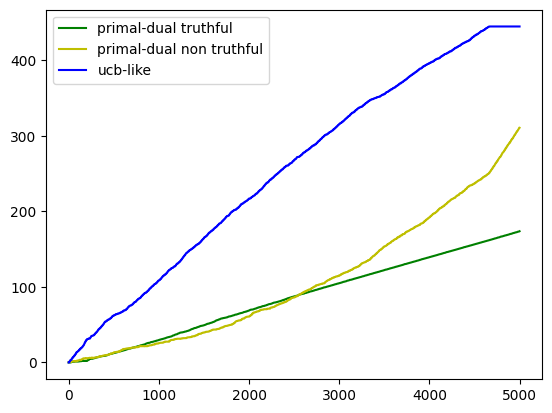

In [12]:
plt.plot(np.cumsum(utilities1), 'g', label= 'primal-dual truthful')
plt.plot(np.cumsum(utilities2), 'y', label= 'primal-dual non truthful')
plt.plot(np.cumsum(utilities3), 'b', label= 'ucb-like')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

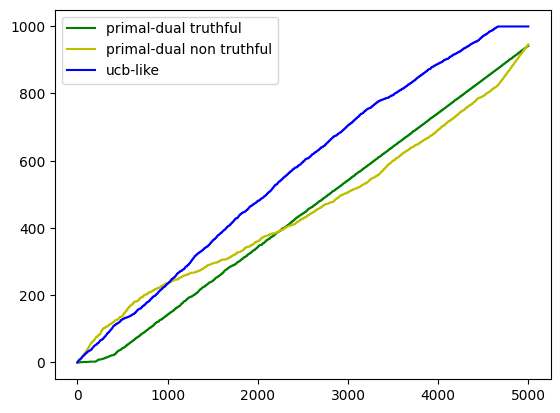

In [13]:
plt.plot(np.cumsum(payments1), 'g', label= 'primal-dual truthful')
plt.plot(np.cumsum(payments2), 'y', label= 'primal-dual non truthful')
plt.plot(np.cumsum(payments3), 'b', label= 'ucb-like')
plt.legend()
plt.show